## Network properties on reconstructed networks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import network_properties
from tqdm import tqdm
from matplotlib import pyplot as plt
import igraph as ig
import numpy as np
from src import renormalizable_model
import scipy
from joblib import Parallel, delayed, cpu_count

Plotting function

In [10]:
def compute_property(graph, property, mode):
    return eval(f"graph.{property}(mode='{mode}')") if mode is not None else eval(f"graph.{property}()")

# def plot_true_expected_original(original_graphs, ensembles, property, x_axis_strengths, mode=None, title=None, xlabel=None, ylabel=None, xscale=None, yscale=None):
#     exp_properties = [np.nanmean([(eval(f"graph.{property}(mode='{mode}')") if mode is not None else eval(f"graph.{property}()")) for graph in tqdm(ensemble)], axis=0) for ensemble in ensembles]
#     true_properties = [(eval(f"graph.{property}(mode='{mode}')") if mode is not None else eval(f"graph.{property}()")) for graph in original_graphs]
#     num_graphs = len(original_graphs)
#     fig, axs = plt.subplots(1, num_graphs, figsize=(20, 5))
#     if title is not None: fig.suptitle(title)
#     if ylabel is not None: axs[0].set(ylabel=ylabel)
#     for i in range(num_graphs):
#         axs[i].scatter(np.log10(x_axis_strengths[i]), true_properties[i], s=10, c="blue", alpha=.5)
#         axs[i].scatter(np.log10(x_axis_strengths[i]), exp_properties[i], s=10, c="red", alpha=.5)
#         axs[i].set(xlabel=xlabel)
#         if xscale is not None: axs[i].set(xscale=xscale)
#         if yscale is not None: axs[i].set(yscale=yscale)

def plot_true_expected(original_graphs, ensembles, property, x_axis_strengths, mode=None, title=None, xlabel=None, ylabel=None, xscale=None, yscale=None, parallel=False):
    if parallel:
        exp_properties = [np.nanmean(Parallel(n_jobs=cpu_count())(delayed(compute_property)(graph, property, mode) for graph in tqdm(ensemble)), axis=0) for ensemble in ensembles]
    else:
        exp_properties = [np.nanmean([(eval(f"graph.{property}(mode='{mode}')") if mode is not None else eval(f"graph.{property}()")) for graph in tqdm(ensemble)], axis=0) for ensemble in ensembles]
    true_properties = [(eval(f"graph.{property}(mode='{mode}')") if mode is not None else eval(f"graph.{property}()")) for graph in original_graphs]
    num_graphs = len(original_graphs)
    fig, axs = plt.subplots(1, num_graphs, figsize=(20, 5))
    if title is not None: fig.suptitle(title)
    if ylabel is not None: axs[0].set(ylabel=ylabel)
    for i in range(num_graphs):
        axs[i].scatter(np.log10(x_axis_strengths[i]), true_properties[i], s=10, c="blue", alpha=.5)
        axs[i].scatter(np.log10(x_axis_strengths[i]), exp_properties[i], s=10, c="red", alpha=.5)
        axs[i].set(xlabel=xlabel)
        if xscale is not None: axs[i].set(xscale=xscale)
        if yscale is not None: axs[i].set(yscale=yscale)

In [11]:
def plot_true_expected_k(original_graphs, ensembles, property, mode=None, title=None, xlabel=None, ylabel=None, xscale=None, yscale=None):
    exp_properties = [np.nanmean([(eval(f"graph.{property}_k(mode='{mode}')") if mode is not None else eval(f"graph.{property}_k()")) for graph in ensemble], axis=0) for ensemble in ensembles]
    true_properties = [eval(f"graph.{property}_k()") for graph in original_graphs]
    num_graphs = len(original_graphs)
    fig, axs = plt.subplots(1, num_graphs, figsize=(20, 5))
    if title is not None: fig.suptitle(title)
    if ylabel is not None: axs[0].set(ylabel=ylabel)
    for i in range(num_graphs):
        axs[i].scatter(range(1, len(true_properties)+1), true_properties[i], s=10, c="blue", alpha=.5)
        axs[i].scatter(range(1, len(exp_properties)+1), exp_properties[i], s=10, c="red", alpha=.5)
        axs[i].set(xlabel=xlabel)
        if xscale is not None: axs[i].set(xscale=xscale)
        if yscale is not None: axs[i].set(yscale=yscale)

Generate ground-truth network

In [3]:
sigma = 2.28
mu = -(sigma**2)/2
size = 500
gen_strengths = np.random.lognormal(mean=mu, sigma=sigma, size=size)
strengths = np.stack([gen_strengths, gen_strengths], axis=1)
z = 0.1

In [4]:
original_graph = renormalizable_model.create_RM_graph(strengths, z)

In [5]:
original_graph.ecount()

5661

In [6]:
density = original_graph.ecount()/(size*size)

In [7]:
density

0.022644

In [8]:
sigma = 2.28
mu = -(sigma**2)/2
size = 500
gen_strengths = np.random.lognormal(mean=mu, sigma=sigma, size=size)
strengths = np.stack([gen_strengths, gen_strengths], axis=1)
z = 0.01

In [9]:
original_graph_2 = renormalizable_model.create_RM_graph(strengths, z)

In [10]:
density = original_graph_2.ecount()/(size*size)

In [11]:
density

0.006504

Infer z value

**TODO 29.11.** 
- Check if z is well estimated by z values inferred from any graph in an ensemble, for different coarse-grainings.
- Network properties consistency
- If needed, consistency of weight assignment HL and LL
- Assume knowledge of strengths but not the density - study properties: degree distributions, degree-strength relationships, knn vs k, c vs k. lambda_max, DebtRank, non-normality, lambda_max of A + A^T / 2 (NEVA network valuatino models)
- 

In [15]:
num_of_links = original_graph.ecount()
in_strengths = original_graph.strength(mode='in', weights=original_graph.es["weight"])
out_strengths = original_graph.strength(mode='out', weights=original_graph.es["weight"])
def exp_num_of_links(z):
    return np.sum([1 - np.exp(-z*x_i*y_j) for x_i, y_j in np.array(np.meshgrid(out_strengths,in_strengths)).T.reshape(-1, 2)]) - num_of_links

In [16]:
exp_z_details = scipy.optimize.root_scalar(exp_num_of_links, method="bisect", bracket=[0,100])
print(exp_z_details)

      converged: True
           flag: converged
 function_calls: 48
     iterations: 46
           root: 0.10100318403232222


In [17]:
exp_z = exp_z_details.root

Generate ensemble using computed strengths

In [18]:
computed_strengths = np.stack([out_strengths, in_strengths], axis=1)
ensemble_size = 1000

In [19]:
ensemble = renormalizable_model.generate_RM_ensemble(ensemble_size, computed_strengths, exp_z, weighted = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:31<00:00, 31.72it/s]


In [20]:
ecounts = [graph.ecount() for graph in ensemble]

In [21]:
print(ecounts)

[5199, 5156, 5180, 5092, 5163, 5232, 5137, 5132, 5189, 5184, 5216, 5116, 5225, 5245, 5091, 5192, 5205, 5181, 5182, 5223, 5164, 5114, 5229, 5256, 5191, 5127, 5133, 5205, 5273, 5171, 5171, 5225, 5281, 5288, 5262, 5156, 5228, 5108, 5206, 5138, 5142, 5237, 5142, 5199, 5130, 5097, 5140, 5134, 5209, 5158, 5209, 5161, 5180, 5141, 5253, 5235, 5259, 5160, 5250, 5177, 5225, 5223, 5208, 5175, 5195, 5228, 5160, 5172, 5231, 5135, 5158, 5228, 5179, 5257, 5100, 5160, 5167, 5092, 5245, 5140, 5166, 5160, 5223, 5312, 5208, 5130, 5215, 5185, 5124, 5183, 5187, 5141, 5113, 5177, 5150, 5207, 5210, 5275, 5179, 5277, 5147, 5147, 5195, 5274, 5169, 5243, 5189, 5180, 5224, 5202, 5101, 5130, 5281, 5254, 5145, 5159, 5172, 5214, 5301, 5217, 5228, 5196, 5282, 5113, 5154, 5173, 5257, 5180, 5211, 5162, 5173, 5170, 5148, 5217, 5219, 5112, 5270, 5234, 5292, 5180, 5214, 5133, 5204, 5233, 5201, 5177, 5083, 5143, 5260, 5242, 5296, 5060, 5202, 5204, 5237, 5218, 5146, 5209, 5174, 5211, 5221, 5101, 5122, 5120, 5164, 5262, 524

In [22]:
exp_ecount = np.mean(ecounts)
print(exp_ecount)

5185.476


## Network properties on coarse-grained networks

We merge part of nodes in one supernode while keeping the rest untouched.

We merge 50, 100 and 200 nodes.

In [23]:
from src import coarse_graining

### Low-level coarse-graining

Compute new weights from initial weights for every graph in the reconstructed ensemble.

In [24]:
coarse_grained_original_50 = coarse_graining.coarse_grain_weighted_graph(original_graph, coarse_graining.merge_n_group(original_graph, 50))
coarse_grained_original_100 = coarse_graining.coarse_grain_weighted_graph(original_graph, coarse_graining.merge_n_group(original_graph, 100))
coarse_grained_original_200 = coarse_graining.coarse_grain_weighted_graph(original_graph, coarse_graining.merge_n_group(original_graph, 200))
coarse_grained_original_400 = coarse_graining.coarse_grain_weighted_graph(original_graph, coarse_graining.merge_n_group(original_graph, 400))

In [37]:
coarse_grained_ensemble_50 = Parallel(n_jobs=cpu_count())(delayed(coarse_graining.coarse_grain_weighted_graph)(graph, coarse_graining.merge_n_group(graph, 50)) for graph in tqdm(ensemble))
coarse_grained_ensemble_100 = Parallel(n_jobs=cpu_count())(delayed(coarse_graining.coarse_grain_weighted_graph)(graph, coarse_graining.merge_n_group(graph, 100)) for graph in tqdm(ensemble))
coarse_grained_ensemble_200 = Parallel(n_jobs=cpu_count())(delayed(coarse_graining.coarse_grain_weighted_graph)(graph, coarse_graining.merge_n_group(graph, 200)) for graph in tqdm(ensemble))
coarse_grained_ensemble_400 = Parallel(n_jobs=cpu_count())(delayed(coarse_graining.coarse_grain_weighted_graph)(graph, coarse_graining.merge_n_group(graph, 400)) for graph in tqdm(ensemble))

100%|██████████| 1000/1000 [00:08<00:00, 113.94it/s]


In [26]:
out_strengths_50, in_strengths_50 = coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 50)).T
out_strengths_100, in_strengths_100 = coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 100)).T
out_strengths_200, in_strengths_200 = coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 200)).T
out_strengths_400, in_strengths_400 = coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 400)).T

#### Degrees

In [28]:
original_graphs = [original_graph, coarse_grained_original_50, coarse_grained_original_100, coarse_grained_original_200, coarse_grained_original_400]
ll_ensembles = [ensemble, coarse_grained_ensemble_50, coarse_grained_ensemble_100, coarse_grained_ensemble_200, coarse_grained_ensemble_400]
x_axis_strengths_out = [out_strengths, out_strengths_50, out_strengths_100, out_strengths_200, out_strengths_400]
x_axis_strengths_in = [in_strengths, in_strengths_50, in_strengths_100, in_strengths_200, in_strengths_400]

100%|██████████| 1000/1000 [00:00<00:00, 121595.18it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_64658/4080005746.py:29: RuntimeWarning: divide by zero encountered in log10
  axs[i].scatter(np.log10(x_axis_strengths[i]), true_properties[i], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_64658/4080005746.py:30: RuntimeWarning: divide by zero encountered in log10
  axs[i].scatter(np.log10(x_axis_strengths[i]), exp_properties[i], s=10, c="red", alpha=.5)


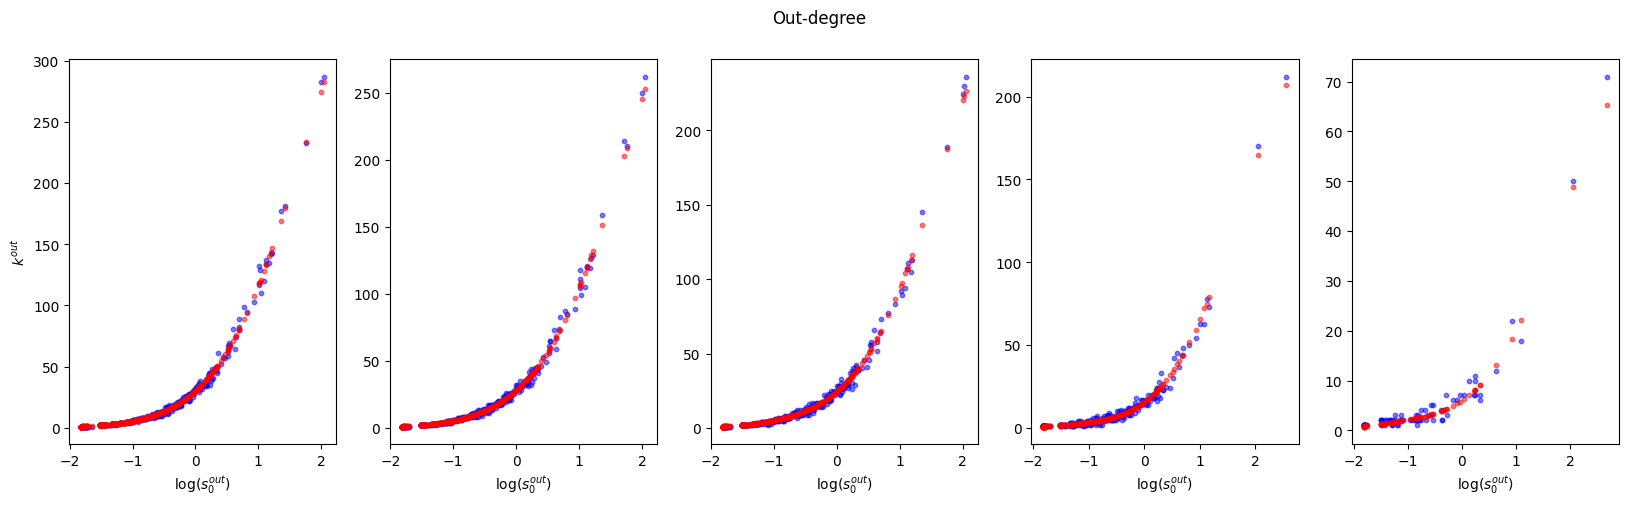

 64%|██████▍   | 640/1000 [00:18<00:04, 81.72it/s]

In [48]:
plot_true_expected(original_graphs, ll_ensembles, "degrees", x_axis_strengths_out, mode="out", title='Out-degree', xlabel=r"$\log(s_0^{out})$", ylabel=r"$k^{out}$")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 103778.31it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75730/1589099224.py:9: RuntimeWarning: divide by zero encountered in log10
  axs[i].scatter(np.log10(x_axis_strengths[i]), true_properties[i], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75730/1589099224.py:10: RuntimeWarning: divide by zero encountered in log10
  axs[i].scatter(np.log10(x_axis_strengths[i]), exp_properties[i], s=10, c="red", alpha=.5)


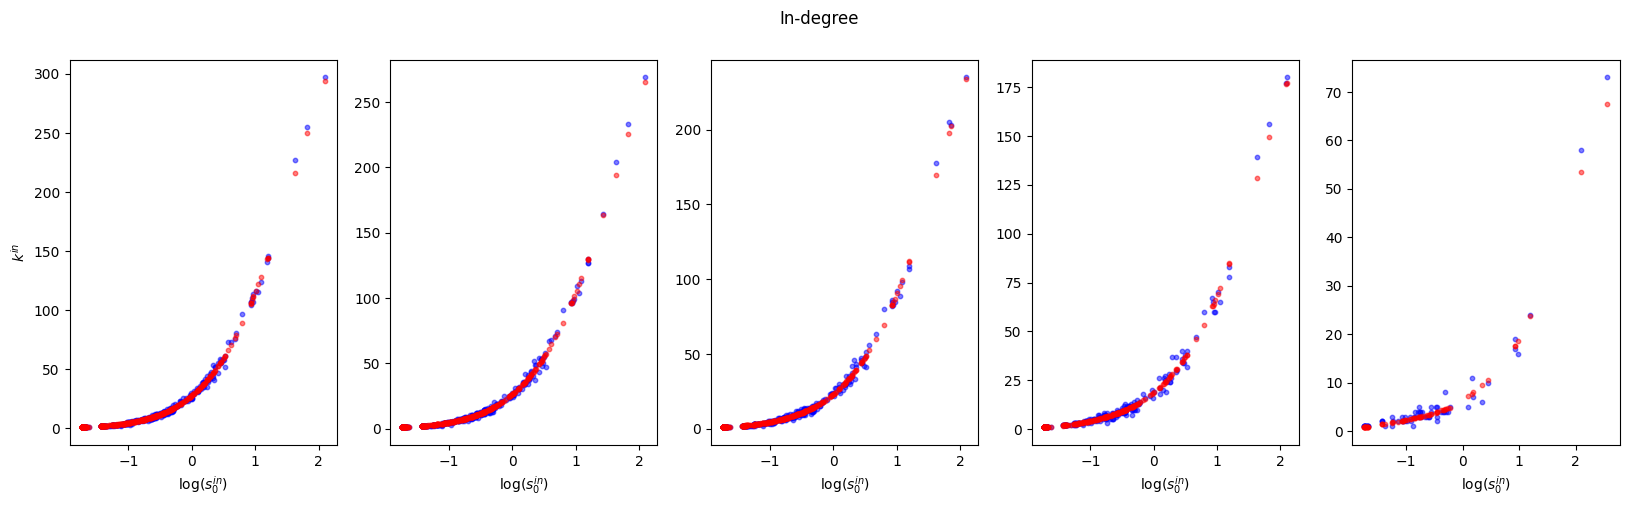

In [22]:
plot_true_expected(original_graphs, ll_ensembles, "degrees", x_axis_strengths_in, mode="in", title='In-degree', xlabel=r"$\log(s_0^{in})$", ylabel=r"$k^{in}$")

Compare stds

In [23]:
coarse_graining_sizes = [0,50,100,200,400]

In [24]:
# ll_std_degrees_out = np.nanstd([graph.degree(mode="out") for graph in ensemble], axis=0)
# ll_std_degrees_out_50 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_50], axis=0)
# ll_std_degrees_out_100 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_100], axis=0)
# ll_std_degrees_out_200 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_200], axis=0)
# ll_std_degrees_out_400 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_400], axis=0)
# hl_std_degrees_out = np.nanstd([graph.degree(mode="out") for graph in ensemble], axis=0)
# hl_std_degrees_out_50 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_50], axis=0)
# hl_std_degrees_out_100 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_100], axis=0)
# hl_std_degrees_out_200 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_200], axis=0)
# hl_std_degrees_out_400 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_400], axis=0)

#### Strengths


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 35947.99it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_64658/4080005746.py:29: RuntimeWarning: divide by zero encountered in log10
  axs[i].scatter(np.log10(x_axis_strengths[i]), true_properties[i], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_64658/4080005746.py:30: RuntimeWarning: divide by zero encountered in log10
  axs[i].scatter(np.log10(x_axis_strengths[i]), exp_properties[i], s=10, c="red", alpha=.5)


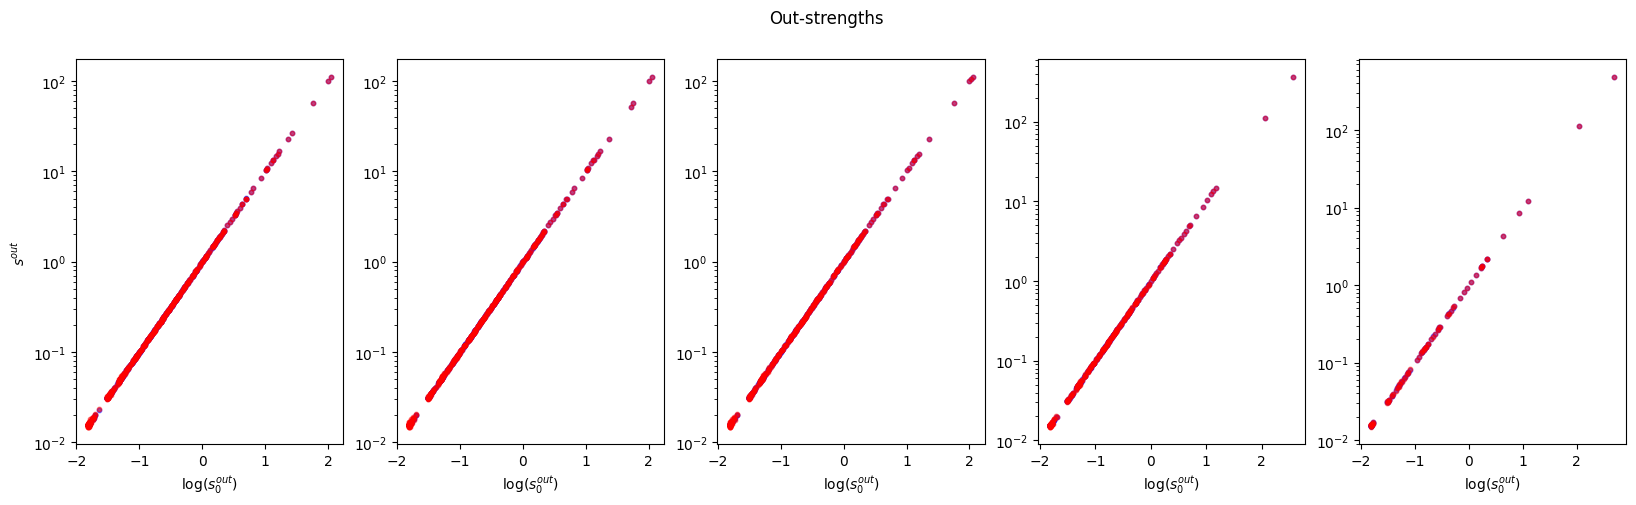

In [49]:
plot_true_expected(original_graphs, ll_ensembles, "strengths", x_axis_strengths_out, mode="out", title='Out-strengths', xlabel=r"$\log(s_0^{out})$", ylabel=r"$s^{out}$", yscale="log")


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 36630.20it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_64658/4080005746.py:29: RuntimeWarning: divide by zero encountered in log10
  axs[i].scatter(np.log10(x_axis_strengths[i]), true_properties[i], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_64658/4080005746.py:30: RuntimeWarning: divide by zero encountered in log10
  axs[i].scatter(np.log10(x_axis_strengths[i]), exp_properties[i], s=10, c="red", alpha=.5)


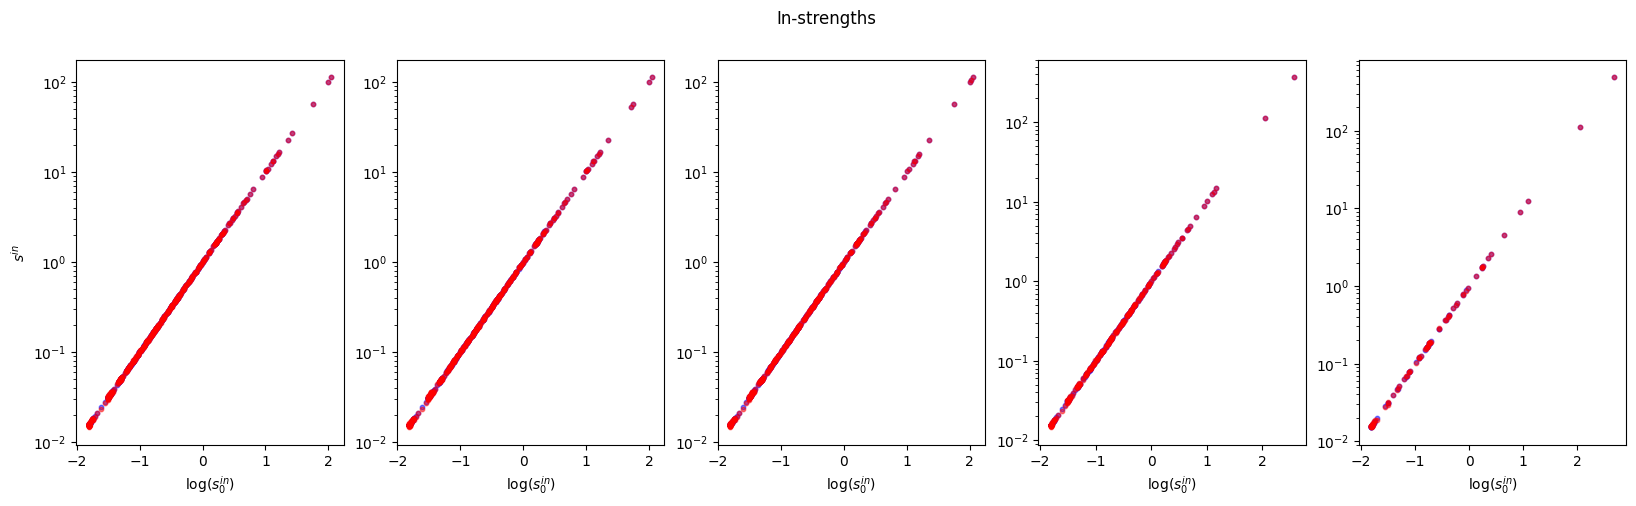

In [50]:
plot_true_expected(original_graphs, ll_ensembles, "strengths", x_axis_strengths_in, mode="in", title='In-strengths', xlabel=r"$\log(s_0^{in})$", ylabel=r"$s^{in}$", yscale="log")

#### Average nearest neighbor degree

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning: invalid value encountered in divide
  annd_k = annd_k/degree_hist
100%|██████████| 1000/1000 [00:07<00:00, 136.22it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_65494/2477709430.py:22: RuntimeWarning: Mean of empty slice
  exp_properties = [np.nanmean([(eval(f"graph.{property}(mode='{mode}')") if mode is not None else eval(f"graph.{property}()")) for graph in tqdm(ensemble)], axis=0) for ensembl

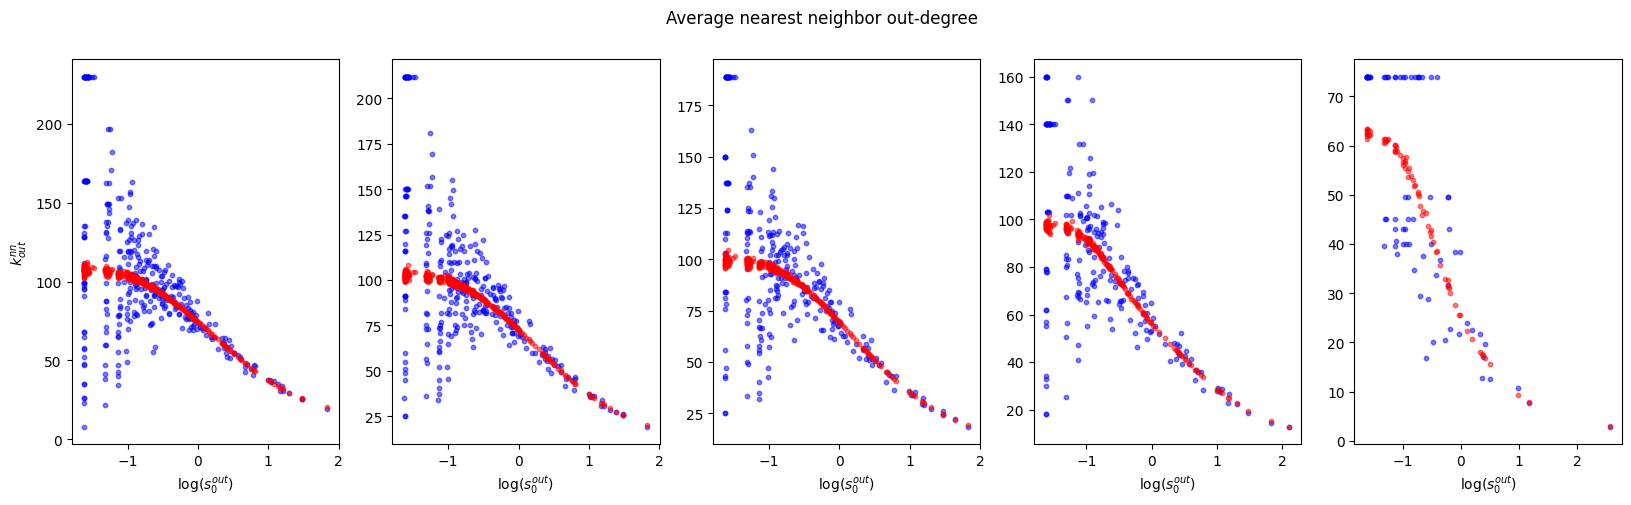

In [31]:
plot_true_expected(original_graphs, ll_ensembles, "annd", x_axis_strengths_out, mode="out", title='Average nearest neighbor out-degree', xlabel=r"$\log(s_0^{out})$", ylabel=r"$k^{nn}_{out}$")

100%|██████████| 1000/1000 [00:08<00:00, 116.73it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75730/1589099224.py:2: RuntimeWarning: Mean of empty slice
  exp_properties = [np.nanmean([(eval(f"graph.{property}(mode='{mode}')") if mode is not None else eval(f"graph.{property}()")) for graph in tqdm(ensemble)], axis=0) for ensemble in ensembles]
100%|██████████| 1000/1000 [00:01<00:00, 724.19it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75730/1589099224.py:9: RuntimeWarning: divide by zero encountered in log10
  axs[i].scatter(np.log10(x_axis_strengths[i]), true_properties[i], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_75730/1589099224.py:10: RuntimeWarning: divide by zero encountered in log10
  axs[i].scatter(np.log10(x_axis_strengths[i]), exp_properties[i], s=10, c="red", alpha=.5)


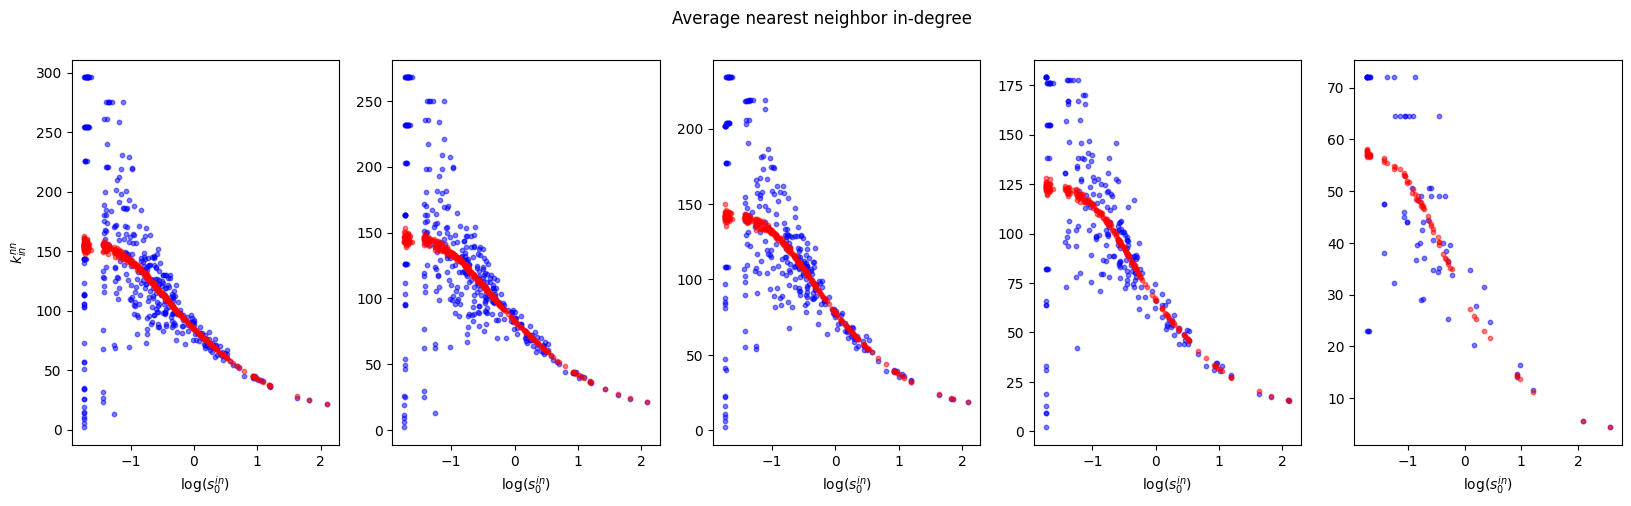

In [28]:
plot_true_expected(original_graphs, ll_ensembles, "annd", x_axis_strengths_in, mode="in", title='Average nearest neighbor in-degree', xlabel=r"$\log(s_0^{in})$", ylabel=r"$k^{nn}_{in}$")

#### Average nearest neighbor strength

100%|██████████| 1000/1000 [00:07<00:00, 134.69it/s]
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:50: RuntimeWarning: invalid value encountered in divide
  result = np.sum(multiplied, axis=1)/np.sum(adj_matrix, axis=1)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:50: RuntimeWarning: invalid value encountered in divide
  result = np.sum(multiplied, axis=1)/np.sum(adj_matrix, axis=1)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:50: RuntimeWarning: invalid value encountered in divide
  result = np.sum(multiplied, axis=1)/np.sum(adj_matrix, axis=1)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:50: RuntimeWarning: invalid value encountered in divide
  result = np.sum(multiplied, axis=1)/np.sum(adj_matrix, axis=1)
/Volumes/Datový disk/FJFI/Leiden/Re

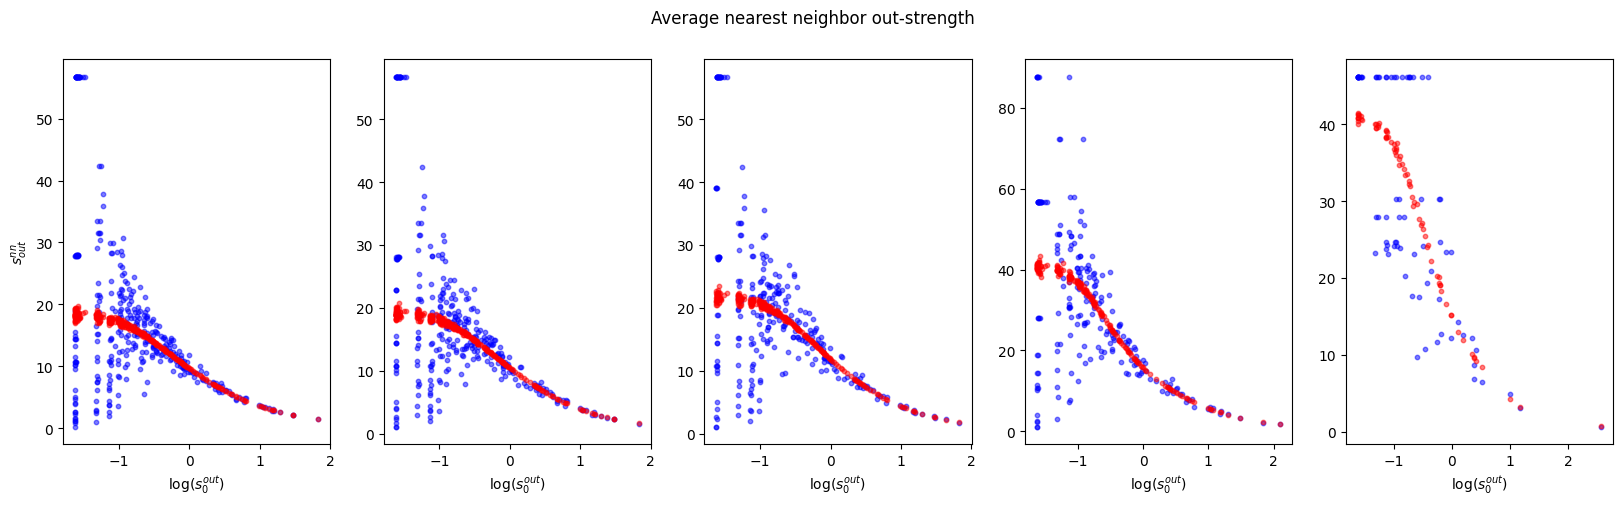

In [38]:
plot_true_expected(original_graphs, ll_ensembles, "anns", x_axis_strengths_out, mode="out", title='Average nearest neighbor out-strength', xlabel=r"$\log(s_0^{out})$", ylabel=r"$s^{nn}_{out}$", parallel=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:53: RuntimeWarning: invalid value encountered in divide
  result = np.sum(multiplied, axis=0)/np.sum(adj_matrix, axis=0)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:53: RuntimeWarning: invalid value encountered in divide
  result = np.sum(multiplied, axis=0)/np.sum(adj_matrix, axis=0)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:53: RuntimeWarning: invalid value encountered in divide
  result = np.sum(multiplied, axis=0)/np.sum(adj_matrix, axis=0)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:53: RuntimeWarning: invalid value encountered in divide
  result = np.sum(multiplied, axis=0)/np.sum(adj_matrix, axis=0)
/Volumes/Datový disk/FJFI/Leiden/Research/Renorm

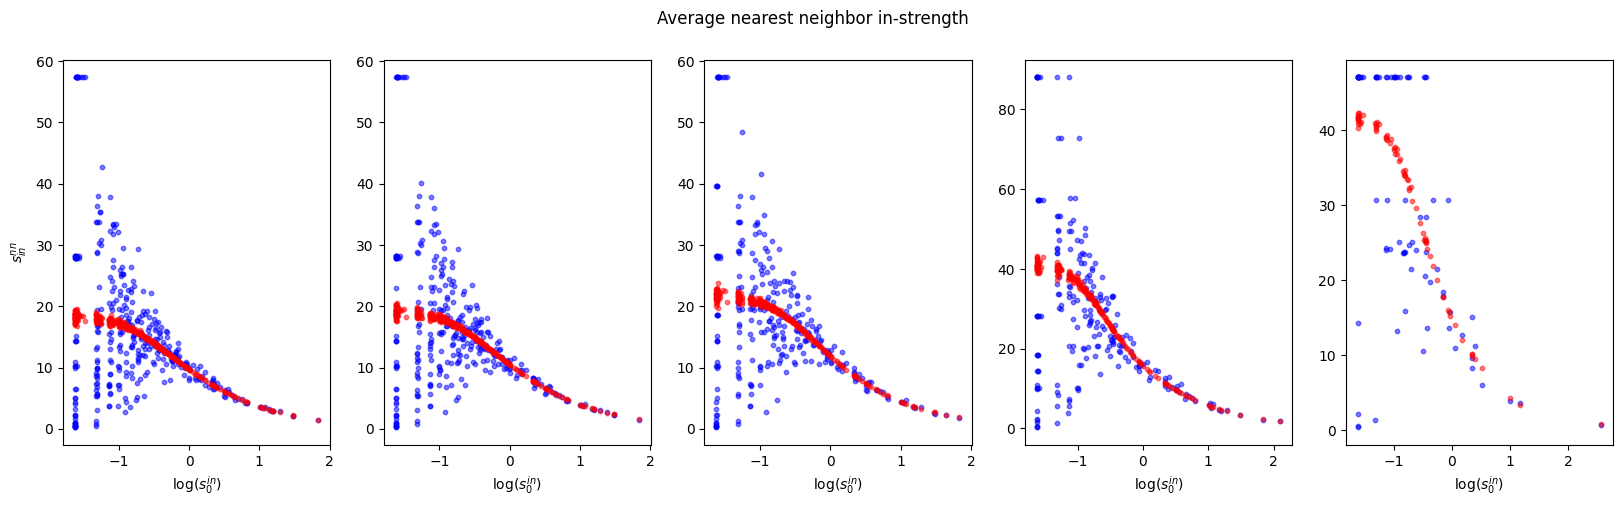

In [33]:
plot_true_expected(original_graphs, ll_ensembles, "anns", x_axis_strengths_in, mode="in", title='Average nearest neighbor in-strength', xlabel=r"$\log(s_0^{in})$", ylabel=r"$s^{nn}_{in}$", parallel=True)

#### Local clustering coefficient

In [36]:
plot_true_expected(original_graphs, ll_ensembles, "clustering_coeff", x_axis_strengths_out, title='Local clustering coefficient', xlabel=r"$\log(s_0^{out})$", ylabel=r"$c_i$", parallel=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

 74%|███████▍  | 740/1000 [00:11<00:03, 69.86it/s]

KeyboardInterrupt: 

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_72670/1192336336.py:2: RuntimeWarning: Mean of empty slice
  exp_properties = [np.nanmean([(eval(f"graph.{property}_k(mode='{mode}')") if mode is not None else eval(f"graph.{property}_k()")) for graph in ensemble], axis=0) for ensemble in ensembles]


ValueError: x and y must be the same size

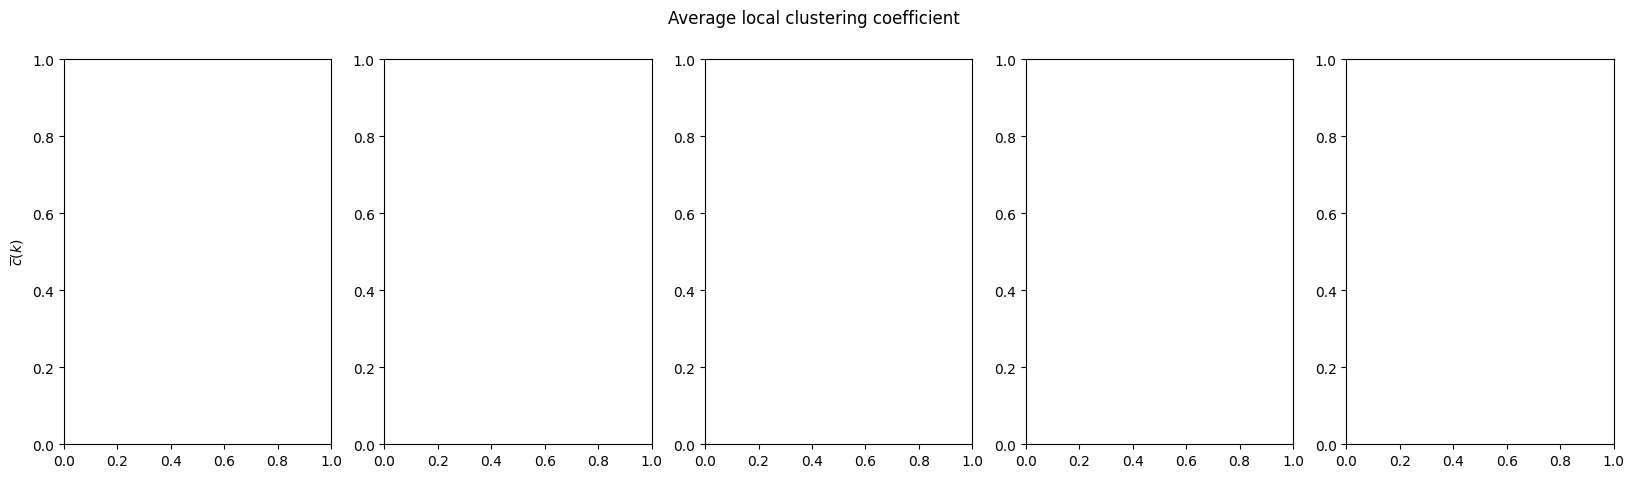

In [ ]:
plot_true_expected_k(original_graphs, ll_ensembles, "clustering_coeff", title='Average local clustering coefficient', xlabel=r"$\log(s_0^{out})$", ylabel=r'$\overline{c}(k)$')

In [ ]:
exp_cl_coeff_k = np.nanmean([exp_cl_coeff_results[i][1] for i in range(len(exp_cl_coeff_results))], axis=0)
exp_cl_coeff_k_50 = np.nanmean([exp_cl_coeff_results_50[i][1] for i in range(len(exp_cl_coeff_results_50))], axis=0)
exp_cl_coeff_k_100 = np.nanmean([exp_cl_coeff_results_100[i][1] for i in range(len(exp_cl_coeff_results_100))], axis=0)
exp_cl_coeff_k_200 = np.nanmean([exp_cl_coeff_results_200[i][1] for i in range(len(exp_cl_coeff_results_200))], axis=0)
exp_cl_coeff_k_400 = np.nanmean([exp_cl_coeff_results_400[i][1] for i in range(len(exp_cl_coeff_results_400))], axis=0)

NameError: name 'exp_cl_coeff_results' is not defined

In [ ]:
obs_cl_coeff_k = network_properties.clustering_coeff(original_graph, len_deg_seq=size)[1]
obs_cl_coeff_k_50 = network_properties.clustering_coeff(coarse_grained_original_50, len_deg_seq=size)[1]
obs_cl_coeff_k_100 = network_properties.clustering_coeff(coarse_grained_original_100, len_deg_seq=size)[1]
obs_cl_coeff_k_200 = network_properties.clustering_coeff(coarse_grained_original_200, len_deg_seq=size)[1]
obs_cl_coeff_k_400 = network_properties.clustering_coeff(coarse_grained_original_400, len_deg_seq=size)[1]

[Text(0.5, 0, '$k$'), None, None]

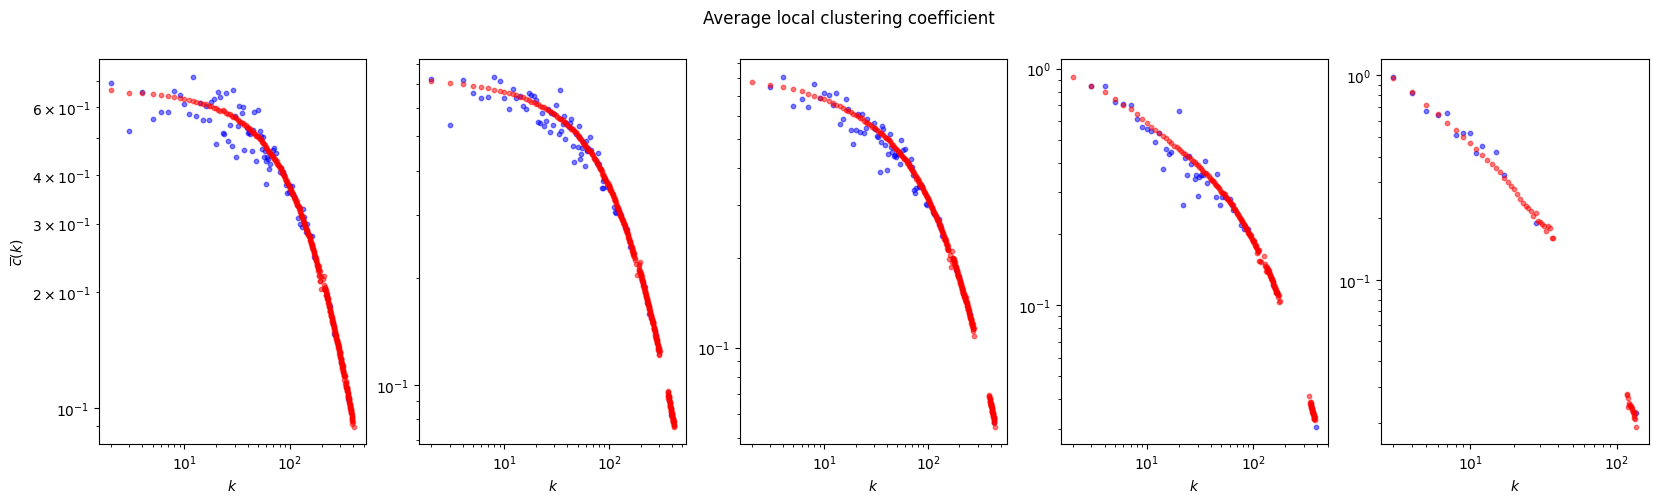

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average local clustering coefficient')

ax1.scatter(range(1, len(obs_cl_coeff_k)+1), obs_cl_coeff_k, s=10, c="blue", alpha=.5)
ax1.scatter(range(1, len(exp_cl_coeff_k)+1), exp_cl_coeff_k, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$k$", ylabel=r'$\overline{c}(k)$', xscale="log", yscale="log")

ax2.scatter(range(1, len(obs_cl_coeff_k_50)+1), obs_cl_coeff_k_50, s=10, c="blue", alpha=.5)
ax2.scatter(range(1, len(exp_cl_coeff_k_50)+1), exp_cl_coeff_k_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$k$", xscale="log", yscale="log")

ax3.scatter(range(1, len(obs_cl_coeff_k_100)+1), obs_cl_coeff_k_100, s=10, c="blue", alpha=.5)
ax3.scatter(range(1, len(exp_cl_coeff_k_100)+1), exp_cl_coeff_k_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$k$", xscale="log", yscale="log")

ax4.scatter(range(1, len(obs_cl_coeff_k_200)+1), obs_cl_coeff_k_200, s=10, c="blue", alpha=.5)
ax4.scatter(range(1, len(exp_cl_coeff_k_200)+1), exp_cl_coeff_k_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$k$", xscale="log", yscale="log")

ax5.scatter(range(1, len(obs_cl_coeff_k_400)+1), obs_cl_coeff_k_400, s=10, c="blue", alpha=.5)
ax5.scatter(range(1, len(exp_cl_coeff_k_400)+1), exp_cl_coeff_k_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$k$", xscale="log", yscale="log")

#### Weighted clustering coefficient

In [ ]:
exp_weighted_cl_coeff = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(ensemble)], axis=0)
exp_weighted_cl_coeff_50 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(coarse_grained_ensemble_50)], axis=0)
exp_weighted_cl_coeff_100 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(coarse_grained_ensemble_100)], axis=0)
exp_weighted_cl_coeff_200 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(coarse_grained_ensemble_200)], axis=0)
exp_weighted_cl_coeff_400 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(coarse_grained_ensemble_400)], axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:98: RuntimeWarning: invalid value encountered in scalar divide
  w_cl_coeff_array[i] = w_cl_coeff_array[i]/num_wedges
100%|██████████| 1000/1000 [02:44<00:00,  6.06it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3344557992.py:1: RuntimeWarning: Mean of empty slice
  exp_weighted_cl_coeff = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(ensemble)], axis=0)
100%|██████████| 1000/1000 [02:14<00:00,  7.42it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3344557992.py:2: RuntimeWarning: Mean of empty slice
  exp_weighted_cl_coeff_50 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(coarse_grained_ensemble_50)], axis=0)
100%|██████████| 1000/1000 [01:29<00:00, 11.15it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/4146884286.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.weighted_clustering_coeff(original_graph), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/4146884286.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), exp_weighted_cl_coeff, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/4146884286.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.weighted_clustering_coeff(coarse_grained_original_50), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/4146884286.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), exp_weighted_cl_coeff_50, c="red", s=10, alpha=.5)
/var/folders/td/zvc

[Text(0.5, 0, '$\\log(s_0^{in})$')]

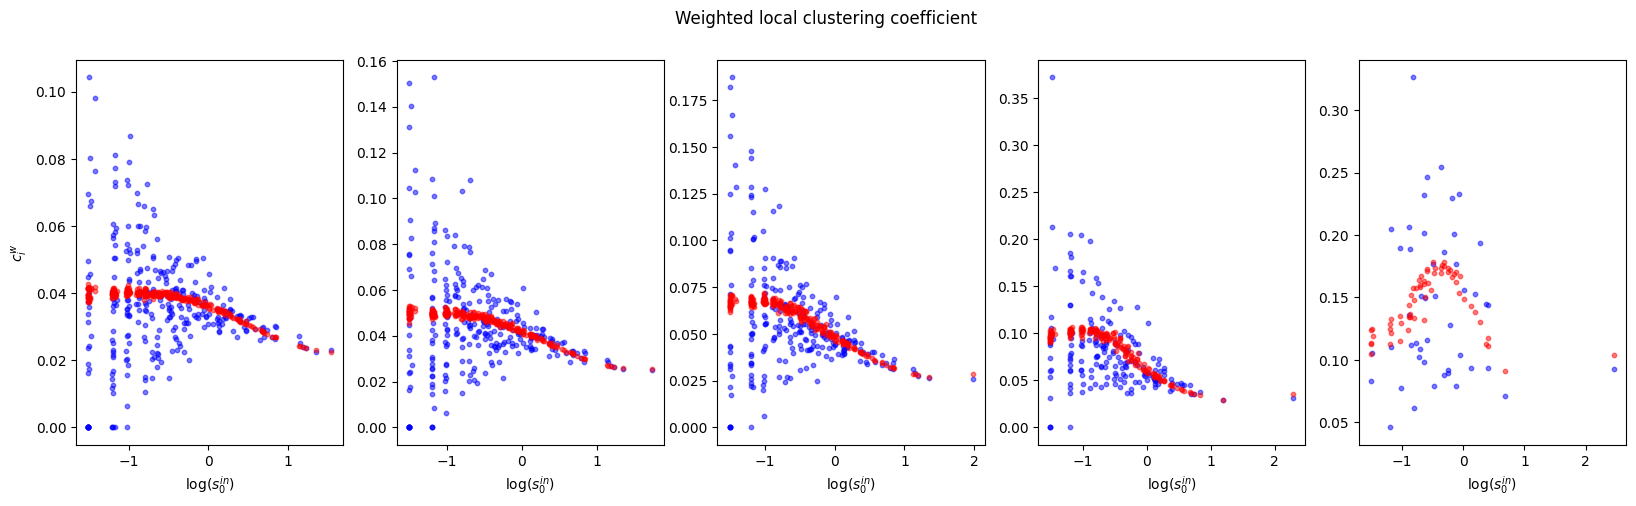

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Weighted local clustering coefficient')

ax1.scatter(np.log10(in_strengths), network_properties.weighted_clustering_coeff(original_graph), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), exp_weighted_cl_coeff, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$c_i^w$")

ax2.scatter(np.log10(in_strengths_50), network_properties.weighted_clustering_coeff(coarse_grained_original_50), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), exp_weighted_cl_coeff_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.weighted_clustering_coeff(coarse_grained_original_100), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), exp_weighted_cl_coeff_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.weighted_clustering_coeff(coarse_grained_original_200), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), exp_weighted_cl_coeff_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.weighted_clustering_coeff(coarse_grained_original_400), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), exp_weighted_cl_coeff_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

### High-level coarse-graining

In [ ]:
hl_coarse_grained_ensemble_50 = renormalizable_model.generate_RM_ensemble(1000, coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 50)), exp_z, weighted=True)
hl_coarse_grained_ensemble_100 = renormalizable_model.generate_RM_ensemble(1000, coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 100)), exp_z, weighted=True)
hl_coarse_grained_ensemble_200 = renormalizable_model.generate_RM_ensemble(1000, coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 200)), exp_z, weighted=True)
hl_coarse_grained_ensemble_400 = renormalizable_model.generate_RM_ensemble(1000, coarse_graining.coarse_grain_strengths(computed_strengths, coarse_graining.merge_n_group(original_graph, 400)), exp_z, weighted=True)

100%|██████████| 1000/1000 [00:10<00:00, 92.76it/s]


#### Degrees

In [ ]:
hl_exp_degrees_out = np.nanmean([graph.degree(mode="out") for graph in ensemble], axis=0)
hl_exp_degrees_out_50 = np.nanmean([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_degrees_out_100 = np.nanmean([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_degrees_out_200 = np.nanmean([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_degrees_out_400 = np.nanmean([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3850525179.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3850525179.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), hl_exp_degrees_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3850525179.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.degree(mode="out"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3850525179.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), hl_exp_degrees_out_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/385052517

[Text(0.5, 0, '$\\log(s_0^{out})$')]

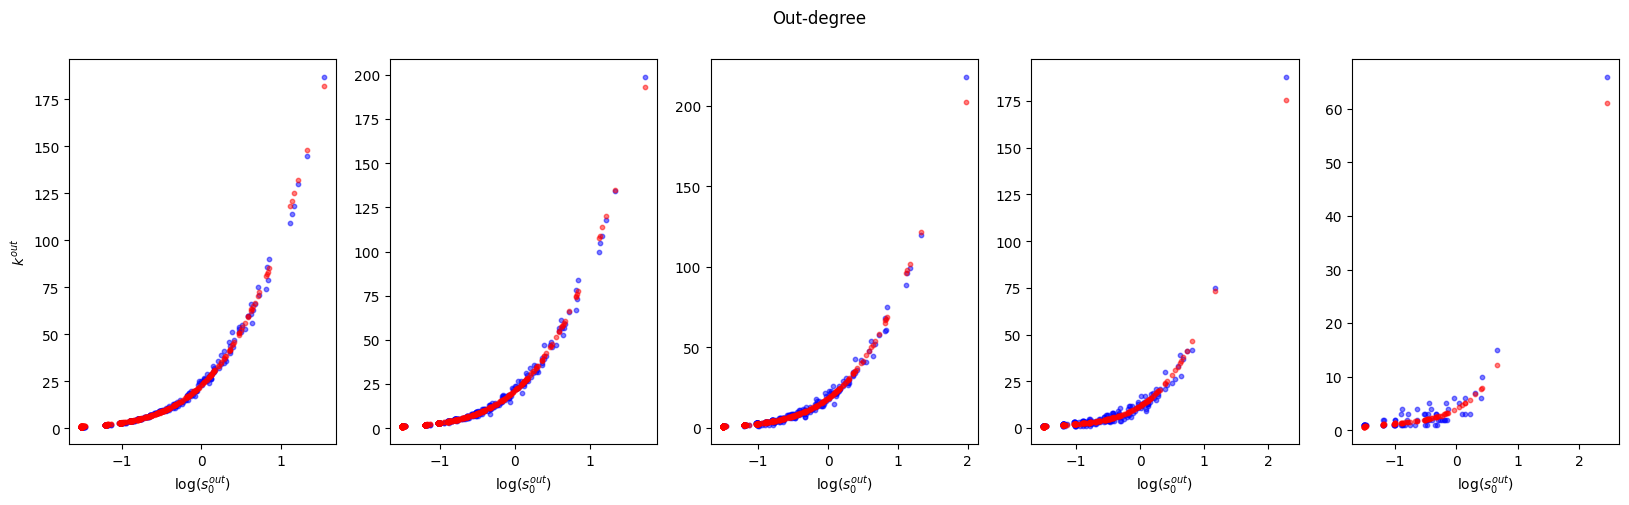

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Out-degree')


ax1.scatter(np.log10(out_strengths), original_graph.degree(mode="out"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), hl_exp_degrees_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$k^{out}$")

ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.degree(mode="out"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), hl_exp_degrees_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$")

ax3.scatter(np.log10(out_strengths_100), coarse_grained_original_100.degree(mode="out"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), hl_exp_degrees_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$")

ax4.scatter(np.log10(out_strengths_200), coarse_grained_original_200.degree(mode="out"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), hl_exp_degrees_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$")

ax5.scatter(np.log10(out_strengths_400), coarse_grained_original_400.degree(mode="out"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), hl_exp_degrees_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$")

In [ ]:
hl_exp_degrees_in = np.nanmean([graph.degree(mode="in") for graph in ensemble], axis=0)
hl_exp_degrees_in_50 = np.nanmean([graph.degree(mode="in") for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_degrees_in_100 = np.nanmean([graph.degree(mode="in") for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_degrees_in_200 = np.nanmean([graph.degree(mode="in") for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_degrees_in_400 = np.nanmean([graph.degree(mode="in") for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1171893534.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), original_graph.degree(mode="in"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1171893534.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), hl_exp_degrees_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1171893534.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.degree(mode="in"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1171893534.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_degrees_in_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1171893534.py:13:

[Text(0.5, 0, '$\\log(s_0^{in})$')]

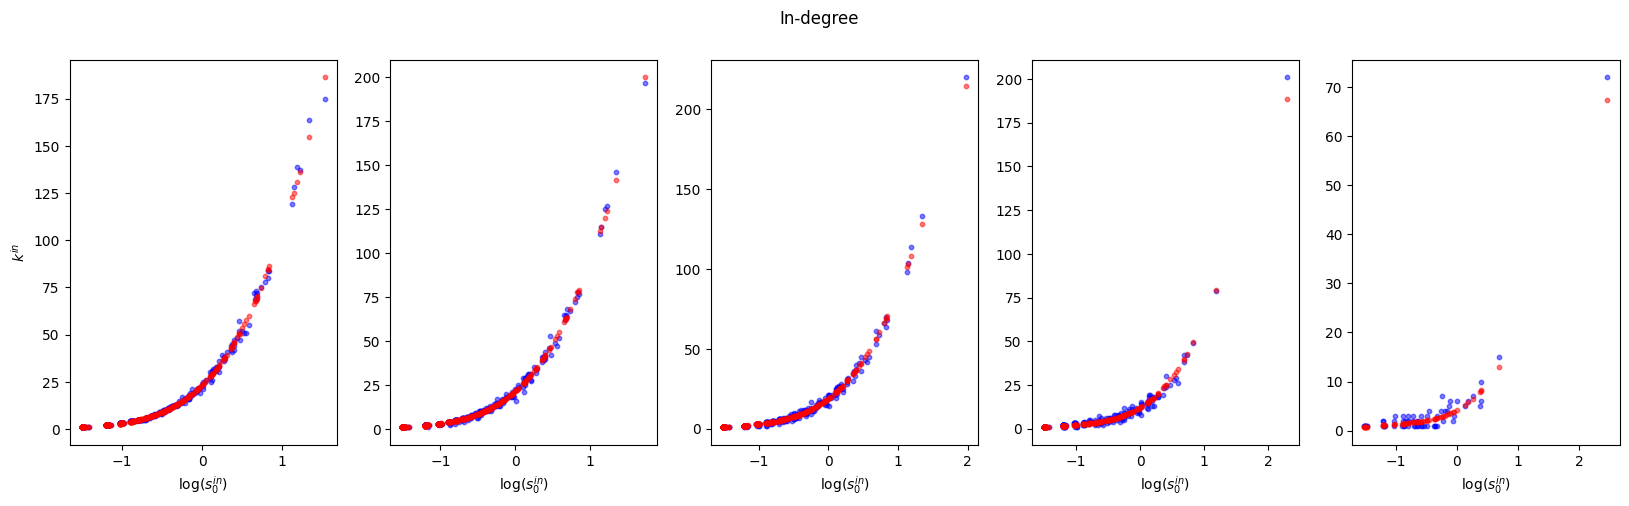

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('In-degree')


ax1.scatter(np.log10(in_strengths), original_graph.degree(mode="in"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), hl_exp_degrees_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$k^{in}$")

ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.degree(mode="in"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_degrees_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), coarse_grained_original_100.degree(mode="in"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_degrees_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), coarse_grained_original_200.degree(mode="in"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_degrees_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), coarse_grained_original_400.degree(mode="in"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_degrees_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

#### Strengths

In [ ]:
hl_exp_strengths_out = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in ensemble], axis=0)
hl_exp_strengths_out_50 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_strengths_out_100 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_strengths_out_200 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_strengths_out_400 = np.nanmean([graph.strength(mode="out", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3131370803.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), original_graph.strength(mode="out", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3131370803.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), hl_exp_strengths_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3131370803.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.strength(mode="out", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3131370803.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), hl_exp_strengths_out_50, c="re

[Text(0.5, 0, '$\\log(s_0^{out})$'), None]

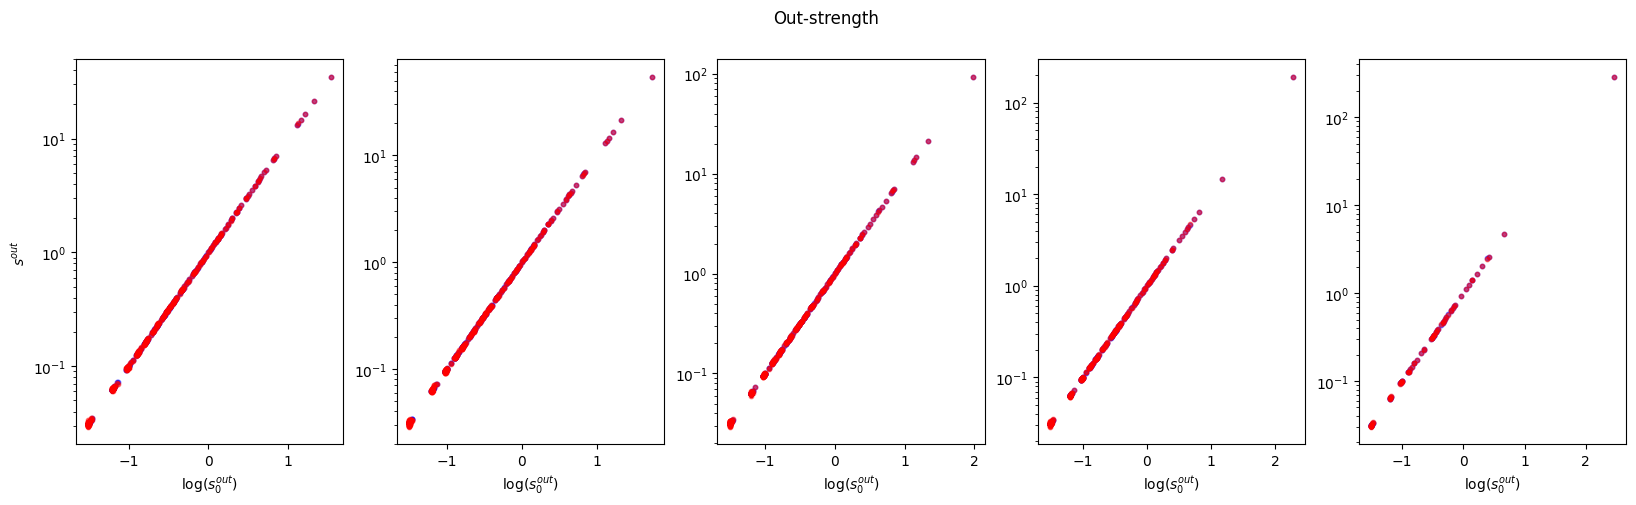

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Out-strength')


ax1.scatter(np.log10(out_strengths), original_graph.strength(mode="out", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), hl_exp_strengths_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$s^{out}$", yscale="log")

ax2.scatter(np.log10(out_strengths_50), coarse_grained_original_50.strength(mode="out", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), hl_exp_strengths_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

ax3.scatter(np.log10(out_strengths_100), coarse_grained_original_100.strength(mode="out", weights=coarse_grained_original_100.es["weight"]), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), hl_exp_strengths_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

ax4.scatter(np.log10(out_strengths_200), coarse_grained_original_200.strength(mode="out", weights=coarse_grained_original_200.es["weight"]), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), hl_exp_strengths_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

ax5.scatter(np.log10(out_strengths_400), coarse_grained_original_400.strength(mode="out", weights=coarse_grained_original_400.es["weight"]), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), hl_exp_strengths_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$", yscale="log")

In [ ]:
hl_exp_strengths_in = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in ensemble], axis=0)
hl_exp_strengths_in_50 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_strengths_in_100 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_strengths_in_200 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_strengths_in_400 = np.nanmean([graph.strength(mode="in", weights=graph.es["weight"]) for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3497945562.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), original_graph.strength(mode="in", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3497945562.py:6: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), hl_exp_strengths_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3497945562.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.strength(mode="in", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3497945562.py:10: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_strengths_in_50, c="red", s=10

[Text(0.5, 0, '$\\log(s_0^{in})$'), None]

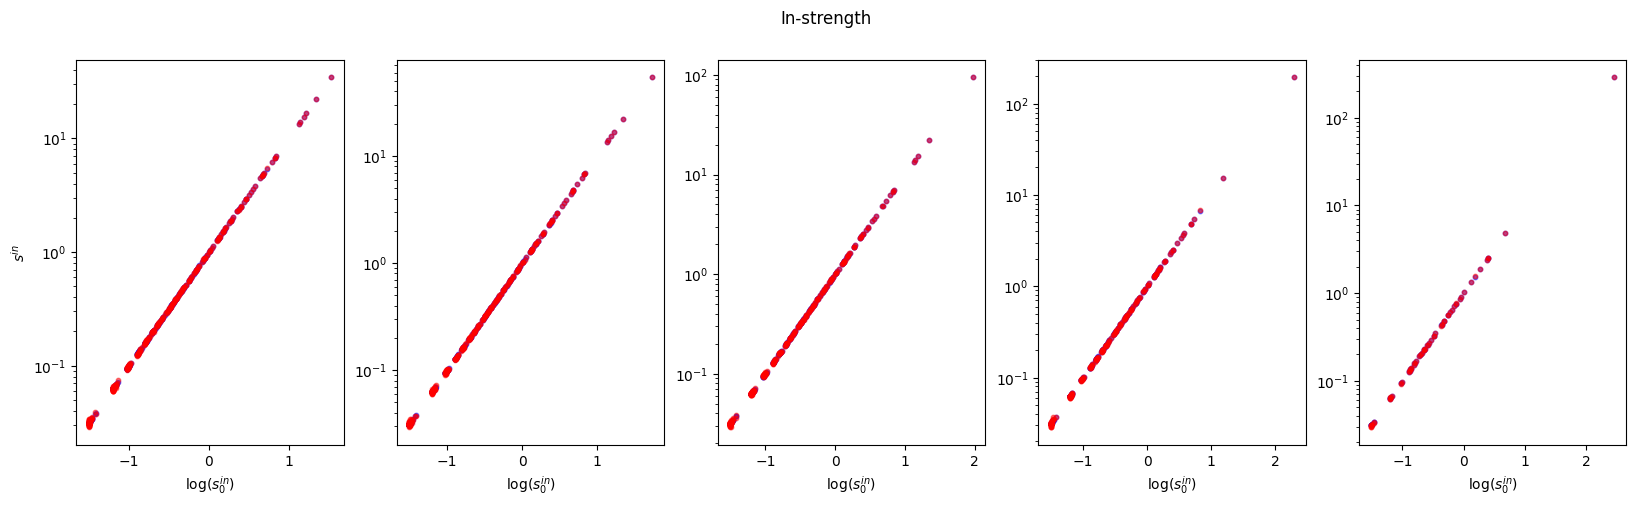

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('In-strength')


ax1.scatter(np.log10(in_strengths), original_graph.strength(mode="in", weights=original_graph.es["weight"]), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), hl_exp_strengths_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$s^{in}$", yscale="log")

ax2.scatter(np.log10(in_strengths_50), coarse_grained_original_50.strength(mode="in", weights=coarse_grained_original_50.es["weight"]), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_strengths_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

ax3.scatter(np.log10(in_strengths_100), coarse_grained_original_100.strength(mode="in", weights=coarse_grained_original_100.es["weight"]), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_strengths_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

ax4.scatter(np.log10(in_strengths_200), coarse_grained_original_200.strength(mode="in", weights=coarse_grained_original_200.es["weight"]), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_strengths_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

ax5.scatter(np.log10(in_strengths_400), coarse_grained_original_400.strength(mode="in", weights=coarse_grained_original_400.es["weight"]), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_strengths_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$", yscale="log")

#### Average nearest neighbor degree

In [ ]:
hl_exp_annd_out = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)
hl_exp_annd_out_50 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_annd_out_100 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_annd_out_200 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_annd_out_400 = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_400], axis=0)

/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning: invalid value encountered in divide
  annd_k = annd_k/degree_hist
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/603284024.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_annd_out = np.nanmean([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/603284024.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_annd_out_50 = np.nanmean([network_pr

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1733561965.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), network_properties.annd(original_graph, mode="out")[0], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1733561965.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), hl_exp_annd_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1733561965.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), network_properties.annd(coarse_grained_original_50, mode="out")[0], s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1733561965.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), hl_exp_annd_out_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x

[Text(0.5, 0, '$\\log(s_0^{out})$')]

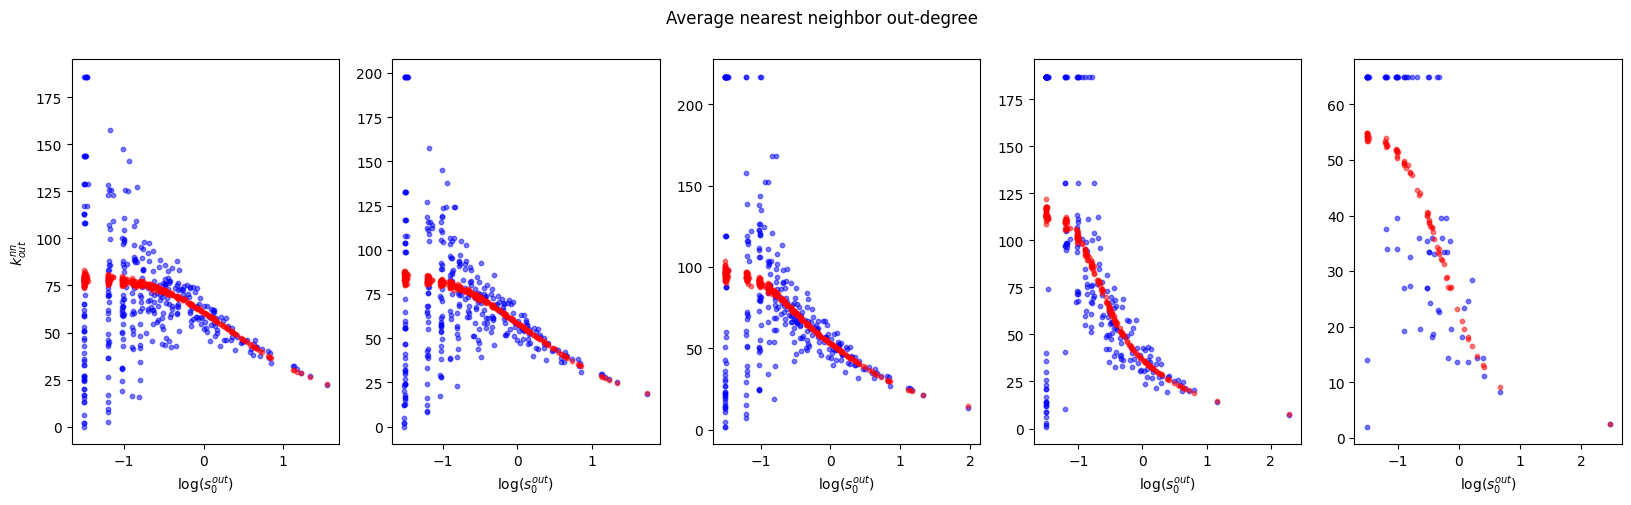

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average nearest neighbor out-degree')

ax1.scatter(np.log10(out_strengths), network_properties.annd(original_graph, mode="out")[0], s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), hl_exp_annd_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$k^{nn}_{out}$")

ax2.scatter(np.log10(out_strengths_50), network_properties.annd(coarse_grained_original_50, mode="out")[0], s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), hl_exp_annd_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$")

ax3.scatter(np.log10(out_strengths_100), network_properties.annd(coarse_grained_original_100, mode="out")[0], s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), hl_exp_annd_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$")

ax4.scatter(np.log10(out_strengths_200), network_properties.annd(coarse_grained_original_200, mode="out")[0], s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), hl_exp_annd_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$")

ax5.scatter(np.log10(out_strengths_400), network_properties.annd(coarse_grained_original_400, mode="out")[0], s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), hl_exp_annd_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$")

In [ ]:
hl_exp_annd_in = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in ensemble], axis=0)
hl_exp_annd_in_50 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_exp_annd_in_100 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_exp_annd_in_200 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_exp_annd_in_400 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/307500238.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_annd_in = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in ensemble], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/307500238.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_annd_in_50 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_50], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/307500238.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_annd_in_100 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_100], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/307500238.py:4: RuntimeWarning: Mean of empty slice
  hl_exp_annd_in_200 = np.nanmean([network_properties.annd(graph, mode="in")[0] for graph in hl_coarse_grained_ensemble_200], axis=0)
/var/folders/td/zvch62c1

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2254953186.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.annd(original_graph, mode="in")[0], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2254953186.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), exp_annd_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2254953186.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.annd(coarse_grained_original_50, mode="in")[0], s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2254953186.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_annd_in_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/i

[Text(0.5, 0, '$\\log(s_0^{in})$')]

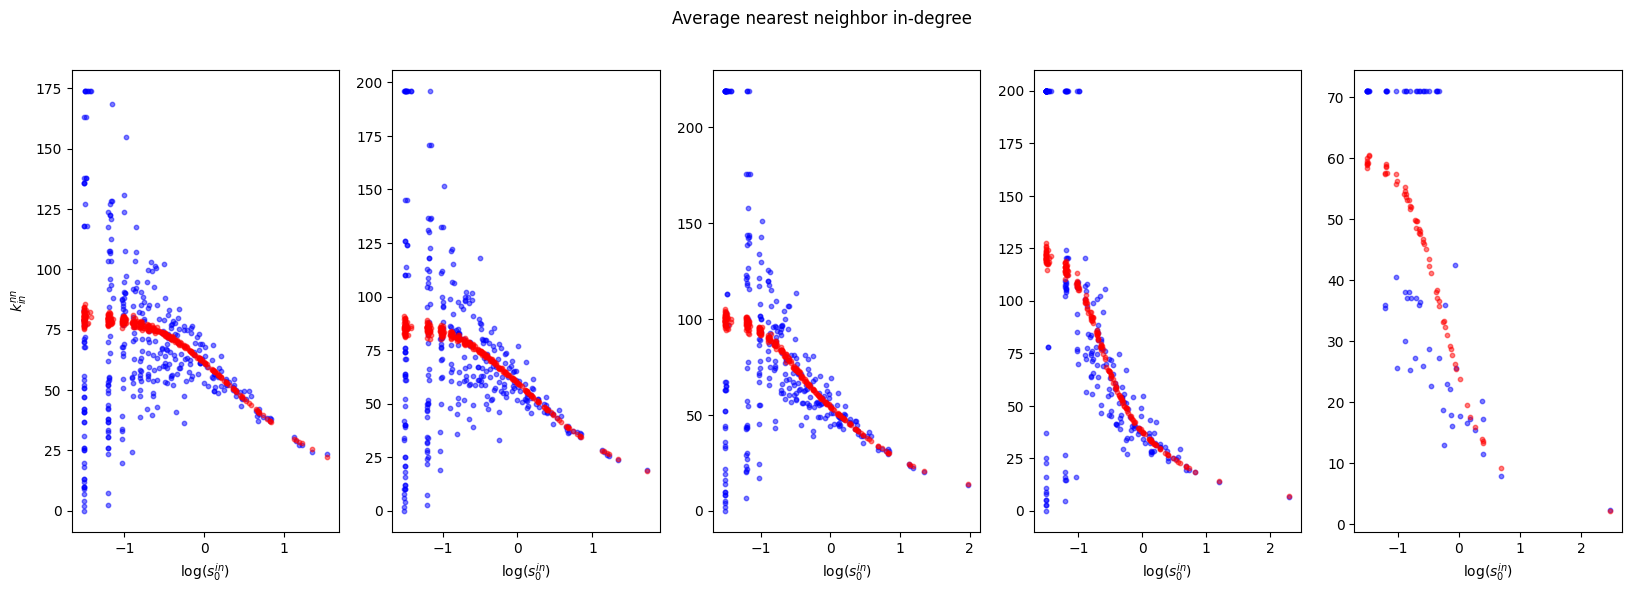

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle('Average nearest neighbor in-degree')

ax1.scatter(np.log10(in_strengths), network_properties.annd(original_graph, mode="in")[0], s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), exp_annd_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$k^{nn}_{in}$")

ax2.scatter(np.log10(in_strengths_50), network_properties.annd(coarse_grained_original_50, mode="in")[0], s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_annd_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.annd(coarse_grained_original_100, mode="in")[0], s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_annd_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.annd(coarse_grained_original_200, mode="in")[0], s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_annd_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.annd(coarse_grained_original_400, mode="in")[0], s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_annd_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

In [ ]:
hl_exp_anns_out = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(ensemble)], axis=0)
hl_exp_anns_out_50 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
hl_exp_anns_out_100 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
hl_exp_anns_out_200 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_200)], axis=0)
hl_exp_anns_out_400 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_400)], axis=0)

100%|██████████| 1000/1000 [03:05<00:00,  5.38it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3389806027.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_anns_out = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(ensemble)], axis=0)
100%|██████████| 1000/1000 [02:37<00:00,  6.37it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3389806027.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_anns_out_50 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
100%|██████████| 1000/1000 [01:55<00:00,  8.66it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3389806027.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_anns_out_100 = np.nanmean([network_properties.anns(graph, mode="out") for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
100%|██████████| 1000/1000 [00:42<00:00, 23.51it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2045376728.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), network_properties.anns(original_graph, mode="out"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2045376728.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(out_strengths), hl_exp_anns_out, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2045376728.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), network_properties.anns(coarse_grained_original_50, mode="out"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2045376728.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(out_strengths_50), hl_exp_anns_out_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000g

[Text(0.5, 0, '$\\log(s_0^{out})$')]

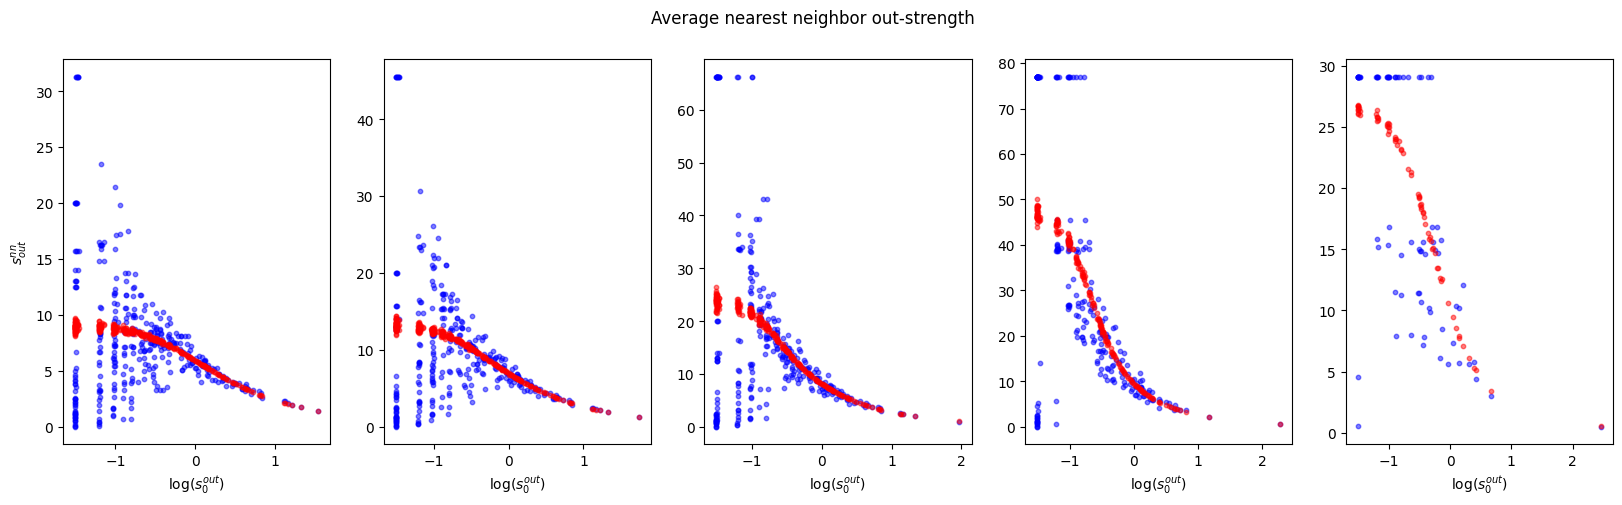

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average nearest neighbor out-strength')

ax1.scatter(np.log10(out_strengths), network_properties.anns(original_graph, mode="out"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(out_strengths), hl_exp_anns_out, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{out})$", ylabel=r"$s^{nn}_{out}$")

ax2.scatter(np.log10(out_strengths_50), network_properties.anns(coarse_grained_original_50, mode="out"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(out_strengths_50), hl_exp_anns_out_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{out})$")

ax3.scatter(np.log10(out_strengths_100), network_properties.anns(coarse_grained_original_100, mode="out"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(out_strengths_100), hl_exp_anns_out_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{out})$")

ax4.scatter(np.log10(out_strengths_200), network_properties.anns(coarse_grained_original_200, mode="out"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(out_strengths_200), hl_exp_anns_out_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{out})$")

ax5.scatter(np.log10(out_strengths_400), network_properties.anns(coarse_grained_original_400, mode="out"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(out_strengths_400), hl_exp_anns_out_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{out})$")

In [ ]:
hl_exp_anns_in = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(ensemble)], axis=0)
hl_exp_anns_in_50 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
hl_exp_anns_in_100 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
hl_exp_anns_in_200 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_200)], axis=0)
hl_exp_anns_in_400 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_400)], axis=0)

100%|██████████| 1000/1000 [03:04<00:00,  5.42it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3556467246.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_anns_in = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(ensemble)], axis=0)
100%|██████████| 1000/1000 [02:33<00:00,  6.51it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3556467246.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_anns_in_50 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
100%|██████████| 1000/1000 [01:55<00:00,  8.69it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3556467246.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_anns_in_100 = np.nanmean([network_properties.anns(graph, mode="in") for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
100%|██████████| 1000/1000 [00:42<00:00, 23.37it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipyker

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1127010426.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.anns(original_graph, mode="in"), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1127010426.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), hl_exp_anns_in, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1127010426.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.anns(coarse_grained_original_50, mode="in"), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1127010426.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_anns_in_50, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipyk

[Text(0.5, 0, '$\\log(s_0^{in})$')]

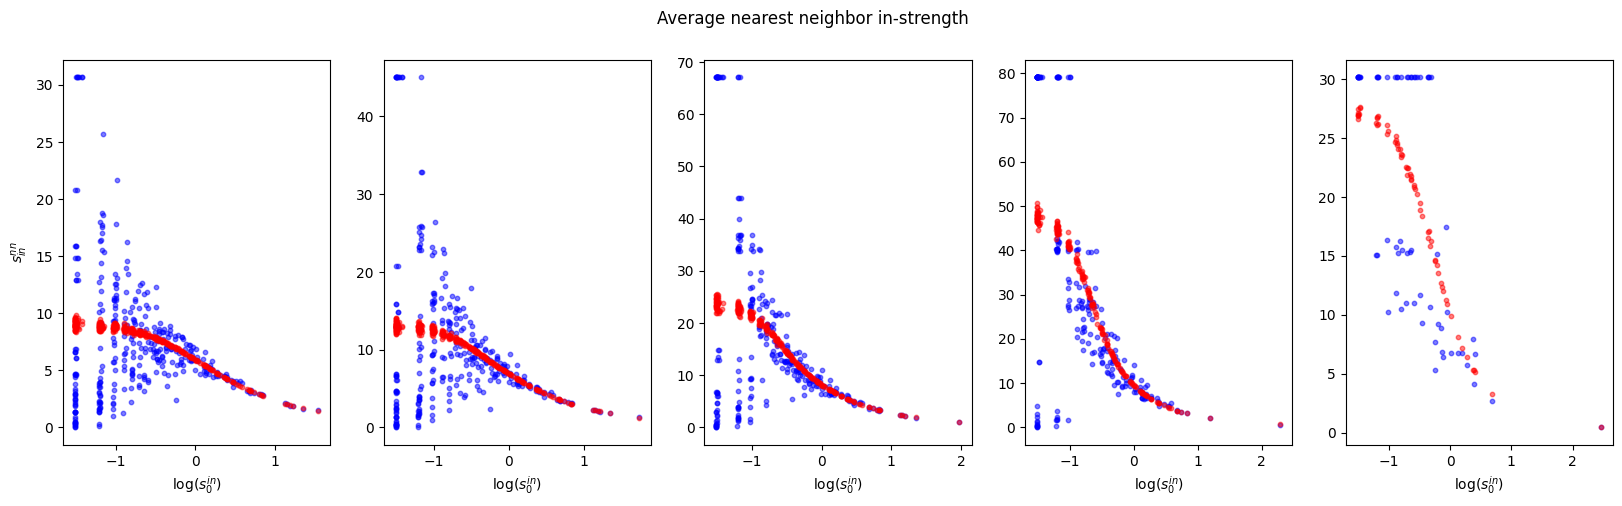

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average nearest neighbor in-strength')

ax1.scatter(np.log10(in_strengths), network_properties.anns(original_graph, mode="in"), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), hl_exp_anns_in, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$s^{nn}_{in}$")

ax2.scatter(np.log10(in_strengths_50), network_properties.anns(coarse_grained_original_50, mode="in"), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_anns_in_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.anns(coarse_grained_original_100, mode="in"), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_anns_in_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.anns(coarse_grained_original_200, mode="in"), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_anns_in_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.anns(coarse_grained_original_400, mode="in"), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_anns_in_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

#### Local clustering coefficient

In [ ]:
hl_exp_cl_coeff_results = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(ensemble)]
hl_exp_cl_coeff_results_50 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(hl_coarse_grained_ensemble_50)]
hl_exp_cl_coeff_results_100 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(hl_coarse_grained_ensemble_100)]
hl_exp_cl_coeff_results_200 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(hl_coarse_grained_ensemble_200)]
hl_exp_cl_coeff_results_400 = [[*network_properties.clustering_coeff(graph,len_deg_seq=size)] for graph in tqdm(hl_coarse_grained_ensemble_400)]

100%|██████████| 1000/1000 [00:03<00:00, 326.78it/s]


In [ ]:
hl_exp_cl_coeff = np.nanmean([hl_exp_cl_coeff_results[i][0] for i in range(len(hl_exp_cl_coeff_results))], axis=0)
hl_exp_cl_coeff_50 = np.nanmean([hl_exp_cl_coeff_results_50[i][0] for i in range(len(hl_exp_cl_coeff_results_50))], axis=0)
hl_exp_cl_coeff_100 = np.nanmean([hl_exp_cl_coeff_results_100[i][0] for i in range(len(hl_exp_cl_coeff_results_100))], axis=0)
hl_exp_cl_coeff_200 = np.nanmean([hl_exp_cl_coeff_results_200[i][0] for i in range(len(hl_exp_cl_coeff_results_200))], axis=0)
hl_exp_cl_coeff_400 = np.nanmean([hl_exp_cl_coeff_results_400[i][0] for i in range(len(hl_exp_cl_coeff_results_400))], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2351783483.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff = np.nanmean([hl_exp_cl_coeff_results[i][0] for i in range(len(hl_exp_cl_coeff_results))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2351783483.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_50 = np.nanmean([hl_exp_cl_coeff_results_50[i][0] for i in range(len(hl_exp_cl_coeff_results_50))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2351783483.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_100 = np.nanmean([hl_exp_cl_coeff_results_100[i][0] for i in range(len(hl_exp_cl_coeff_results_100))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2351783483.py:4: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_200 = np.nanmean([hl_exp_cl_coeff_results_200[i][0] for i in range(len(hl_exp_cl_coeff_results_200))], axis=0)
/var/folders/td/zvch62c16b7

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2851414236.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.clustering_coeff(original_graph,len_deg_seq=size)[0], s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2851414236.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), hl_exp_cl_coeff, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2851414236.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.clustering_coeff(coarse_grained_original_50,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2851414236.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_cl_coeff_50, c="red", s=10, alpha=.5)
/var/fold

[Text(0.5, 0, '$\\log(s_0^{in})$')]

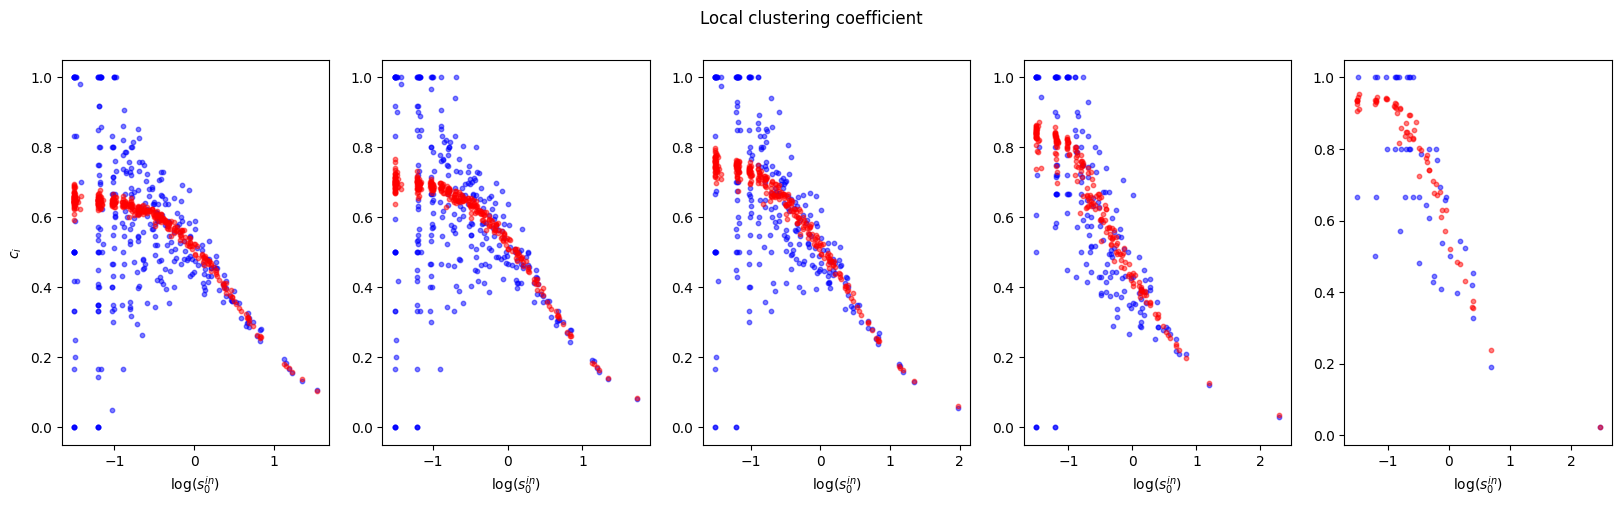

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Local clustering coefficient')

ax1.scatter(np.log10(in_strengths), network_properties.clustering_coeff(original_graph,len_deg_seq=size)[0], s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), hl_exp_cl_coeff, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$c_i$")

ax2.scatter(np.log10(in_strengths_50), network_properties.clustering_coeff(coarse_grained_original_50,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_cl_coeff_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.clustering_coeff(coarse_grained_original_100,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_cl_coeff_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.clustering_coeff(coarse_grained_original_200,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_cl_coeff_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.clustering_coeff(coarse_grained_original_400,len_deg_seq=size)[0], s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_cl_coeff_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

In [ ]:
hl_exp_cl_coeff_k = np.nanmean([hl_exp_cl_coeff_results[i][1] for i in range(len(hl_exp_cl_coeff_results))], axis=0)
hl_exp_cl_coeff_k_50 = np.nanmean([hl_exp_cl_coeff_results_50[i][1] for i in range(len(hl_exp_cl_coeff_results_50))], axis=0)
hl_exp_cl_coeff_k_100 = np.nanmean([hl_exp_cl_coeff_results_100[i][1] for i in range(len(hl_exp_cl_coeff_results_100))], axis=0)
hl_exp_cl_coeff_k_200 = np.nanmean([hl_exp_cl_coeff_results_200[i][1] for i in range(len(hl_exp_cl_coeff_results_200))], axis=0)
hl_exp_cl_coeff_k_400 = np.nanmean([hl_exp_cl_coeff_results_400[i][1] for i in range(len(hl_exp_cl_coeff_results_400))], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2039684858.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_k = np.nanmean([hl_exp_cl_coeff_results[i][1] for i in range(len(hl_exp_cl_coeff_results))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2039684858.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_k_50 = np.nanmean([hl_exp_cl_coeff_results_50[i][1] for i in range(len(hl_exp_cl_coeff_results_50))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2039684858.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_k_100 = np.nanmean([hl_exp_cl_coeff_results_100[i][1] for i in range(len(hl_exp_cl_coeff_results_100))], axis=0)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2039684858.py:4: RuntimeWarning: Mean of empty slice
  hl_exp_cl_coeff_k_200 = np.nanmean([hl_exp_cl_coeff_results_200[i][1] for i in range(len(hl_exp_cl_coeff_results_200))], axis=0)
/var/folders/td/zvc

In [ ]:
obs_cl_coeff_k = network_properties.clustering_coeff(original_graph,len_deg_seq=size)[1]
obs_cl_coeff_k_50 = network_properties.clustering_coeff(coarse_grained_original_50,len_deg_seq=size)[1]
obs_cl_coeff_k_100 = network_properties.clustering_coeff(coarse_grained_original_100,len_deg_seq=size)[1]
obs_cl_coeff_k_200 = network_properties.clustering_coeff(coarse_grained_original_200,len_deg_seq=size)[1]
obs_cl_coeff_k_400 = network_properties.clustering_coeff(coarse_grained_original_400,len_deg_seq=size)[1]

[Text(0.5, 0, '$k$'), None, None]

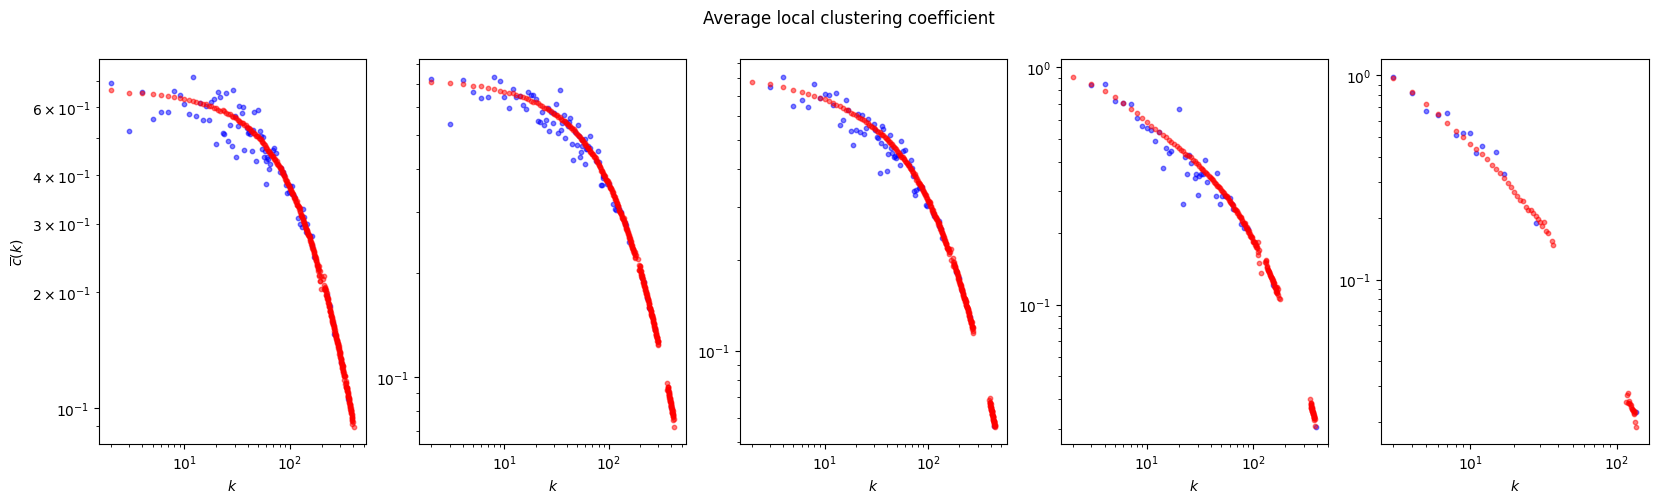

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Average local clustering coefficient')

ax1.scatter(range(1, len(obs_cl_coeff_k)+1), obs_cl_coeff_k, s=10, c="blue", alpha=.5)
ax1.scatter(range(1, len(hl_exp_cl_coeff_k)+1), hl_exp_cl_coeff_k, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$k$", ylabel=r'$\overline{c}(k)$', xscale="log", yscale="log")

ax2.scatter(range(1, len(obs_cl_coeff_k_50)+1), obs_cl_coeff_k_50, s=10, c="blue", alpha=.5)
ax2.scatter(range(1, len(hl_exp_cl_coeff_k_50)+1), hl_exp_cl_coeff_k_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$k$", xscale="log", yscale="log")

ax3.scatter(range(1, len(obs_cl_coeff_k_100)+1), obs_cl_coeff_k_100, s=10, c="blue", alpha=.5)
ax3.scatter(range(1, len(hl_exp_cl_coeff_k_100)+1), hl_exp_cl_coeff_k_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$k$", xscale="log", yscale="log")

ax4.scatter(range(1, len(obs_cl_coeff_k_200)+1), obs_cl_coeff_k_200, s=10, c="blue", alpha=.5)
ax4.scatter(range(1, len(hl_exp_cl_coeff_k_200)+1), hl_exp_cl_coeff_k_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$k$", xscale="log", yscale="log")

ax5.scatter(range(1, len(obs_cl_coeff_k_400)+1), obs_cl_coeff_k_400, s=10, c="blue", alpha=.5)
ax5.scatter(range(1, len(hl_exp_cl_coeff_k_400)+1), hl_exp_cl_coeff_k_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$k$", xscale="log", yscale="log")

#### Weighted local clustering coefficient

In [ ]:
hl_exp_weighted_cl_coeff = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(ensemble)], axis=0)
hl_exp_weighted_cl_coeff_50 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
hl_exp_weighted_cl_coeff_100 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
hl_exp_weighted_cl_coeff_200 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_200)], axis=0)
hl_exp_weighted_cl_coeff_400 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_400)], axis=0)

100%|██████████| 1000/1000 [02:44<00:00,  6.07it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2481365804.py:1: RuntimeWarning: Mean of empty slice
  hl_exp_weighted_cl_coeff = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(ensemble)], axis=0)
100%|██████████| 1000/1000 [02:11<00:00,  7.63it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2481365804.py:2: RuntimeWarning: Mean of empty slice
  hl_exp_weighted_cl_coeff_50 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_50)], axis=0)
100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/2481365804.py:3: RuntimeWarning: Mean of empty slice
  hl_exp_weighted_cl_coeff_100 = np.nanmean([network_properties.weighted_clustering_coeff(graph) for graph in tqdm(hl_coarse_grained_ensemble_100)], axis=0)
100%|██████████| 1000/1000 [00:24<00:00, 41.09i

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1253335618.py:4: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), network_properties.weighted_clustering_coeff(original_graph), s=10, c="blue", alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1253335618.py:5: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(np.log10(in_strengths), hl_exp_weighted_cl_coeff, c="red", s=10, alpha=.5)
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1253335618.py:8: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), network_properties.weighted_clustering_coeff(coarse_grained_original_50), s=10, alpha=.5, c="blue")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1253335618.py:9: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(np.log10(in_strengths_50), hl_exp_weighted_cl_coeff_50, c="red", s=10, alpha=.5)
/var/folders/

[Text(0.5, 0, '$\\log(s_0^{in})$')]

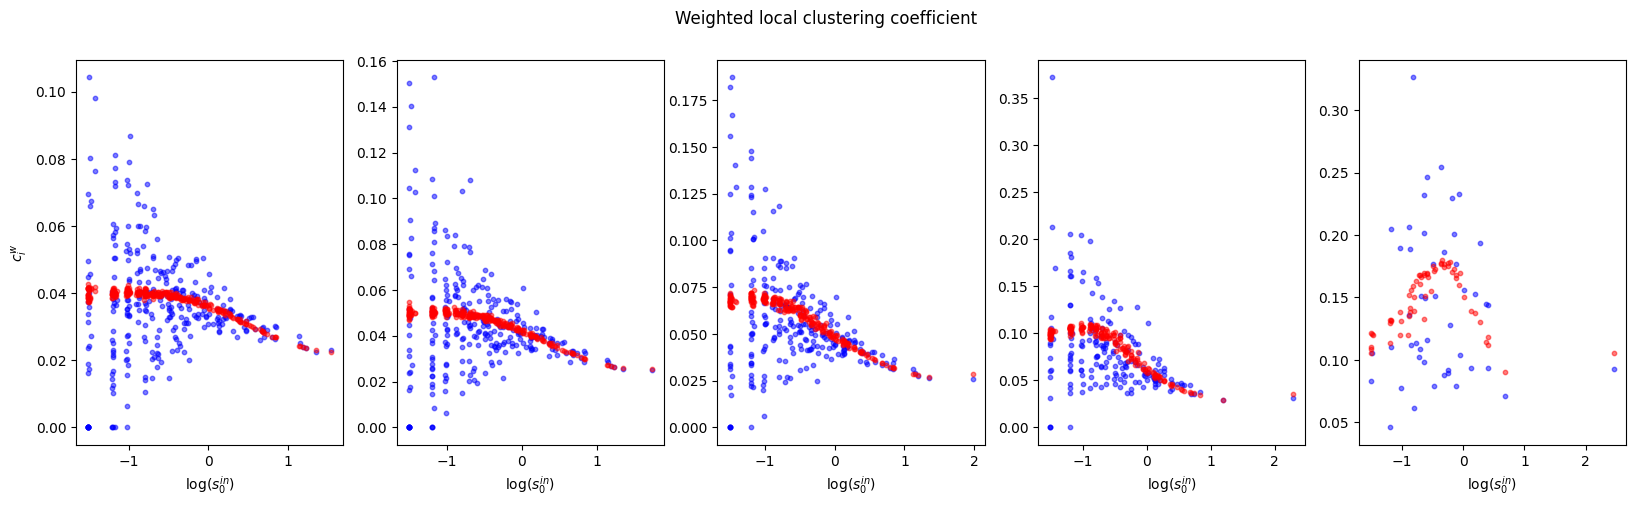

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Weighted local clustering coefficient')

ax1.scatter(np.log10(in_strengths), network_properties.weighted_clustering_coeff(original_graph), s=10, c="blue", alpha=.5)
ax1.scatter(np.log10(in_strengths), hl_exp_weighted_cl_coeff, c="red", s=10, alpha=.5)
ax1.set(xlabel=r"$\log(s_0^{in})$", ylabel=r"$c_i^w$")

ax2.scatter(np.log10(in_strengths_50), network_properties.weighted_clustering_coeff(coarse_grained_original_50), s=10, alpha=.5, c="blue")
ax2.scatter(np.log10(in_strengths_50), hl_exp_weighted_cl_coeff_50, c="red", s=10, alpha=.5)
ax2.set(xlabel=r"$\log(s_0^{in})$")

ax3.scatter(np.log10(in_strengths_100), network_properties.weighted_clustering_coeff(coarse_grained_original_100), s=10, alpha=.5, c="blue")
ax3.scatter(np.log10(in_strengths_100), hl_exp_weighted_cl_coeff_100, c="red", s=10, alpha=.5)
ax3.set(xlabel=r"$\log(s_0^{in})$")

ax4.scatter(np.log10(in_strengths_200), network_properties.weighted_clustering_coeff(coarse_grained_original_200), s=10, alpha=.5, c="blue")
ax4.scatter(np.log10(in_strengths_200), hl_exp_weighted_cl_coeff_200, c="red", s=10, alpha=.5)
ax4.set(xlabel=r"$\log(s_0^{in})$")

ax5.scatter(np.log10(in_strengths_400), network_properties.weighted_clustering_coeff(coarse_grained_original_400), s=10, alpha=.5, c="blue")
ax5.scatter(np.log10(in_strengths_400), hl_exp_weighted_cl_coeff_400, c="red", s=10, alpha=.5)
ax5.set(xlabel=r"$\log(s_0^{in})$")

## Compare low-level and high-level coarsegraining

### Degrees

In [ ]:
ll_std_degrees_out = np.nanstd([graph.degree(mode="out") for graph in ensemble], axis=0)
ll_std_degrees_out_50 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_50], axis=0)
ll_std_degrees_out_100 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_100], axis=0)
ll_std_degrees_out_200 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_200], axis=0)
ll_std_degrees_out_400 = np.nanstd([graph.degree(mode="out") for graph in coarse_grained_ensemble_400], axis=0)

In [ ]:
hl_std_degrees_out = np.nanstd([graph.degree(mode="out") for graph in ensemble], axis=0)
hl_std_degrees_out_50 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_std_degrees_out_100 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_std_degrees_out_200 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_std_degrees_out_400 = np.nanstd([graph.degree(mode="out") for graph in hl_coarse_grained_ensemble_400], axis=0)

NameError: name 'hl_coarse_grained_ensemble_50' is not defined

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/956606765.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), ll_std_degrees_out_50, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/956606765.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), hl_std_degrees_out_50, s=10, alpha=.5, label="High-level")


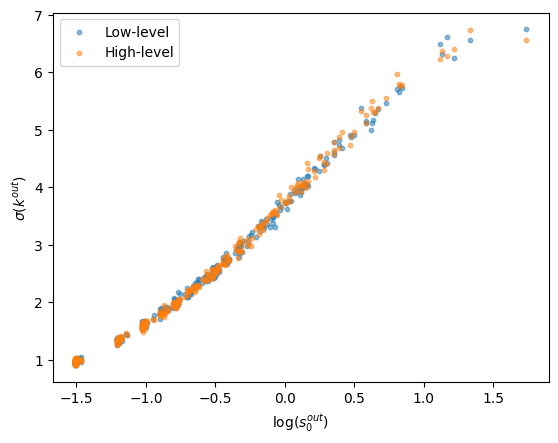

In [ ]:
plt.scatter(np.log10(out_strengths_50), ll_std_degrees_out_50, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_50), hl_std_degrees_out_50, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(k^{out})$")
plt.legend()

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/778241222.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_200), ll_std_degrees_out_200, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/778241222.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_200), hl_std_degrees_out_200, s=10, alpha=.5, label="High-level")


Text(0, 0.5, '$\\sigma(k^{out})$')

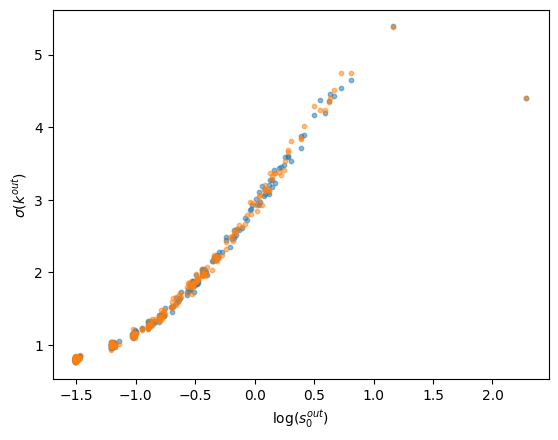

In [ ]:
plt.scatter(np.log10(out_strengths_200), ll_std_degrees_out_200, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_200), hl_std_degrees_out_200, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(k^{out})$")

### Average nearest neighbor degree

In [ ]:
ll_std_annd_out = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)
ll_std_annd_out_50 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_50], axis=0)
ll_std_annd_out_100 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_100], axis=0)
ll_std_annd_out_200 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_200], axis=0)
ll_std_annd_out_400 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in coarse_grained_ensemble_400], axis=0)

/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Volumes/Datový disk/FJFI/Leiden/Research/Renormalization-Network-Reconstruction/src/network_properties.py:19: RuntimeWarning: invalid value encountered in divide
  annd_k = annd_k/degree_hist
/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
hl_std_annd_out = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in ensemble], axis=0)
hl_std_annd_out_50 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_50], axis=0)
hl_std_annd_out_100 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_100], axis=0)
hl_std_annd_out_200 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_200], axis=0)
hl_std_annd_out_400 = np.nanstd([network_properties.annd(graph, mode="out")[0] for graph in hl_coarse_grained_ensemble_400], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1310423869.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), ll_std_annd_out_50, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1310423869.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), hl_std_annd_out_50, s=10, alpha=.5, label="High-level")


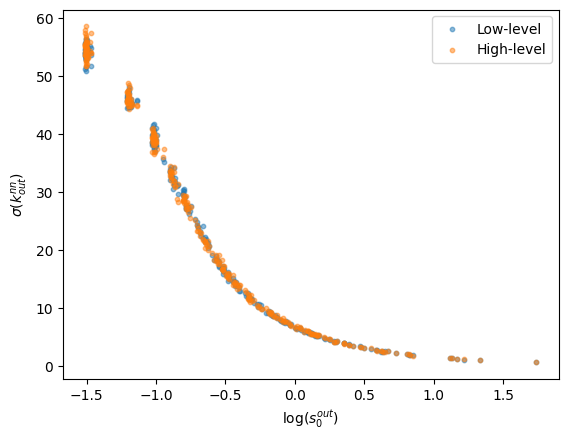

In [ ]:
plt.scatter(np.log10(out_strengths_50), ll_std_annd_out_50, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_50), hl_std_annd_out_50, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(k^{nn}_{out})$")
plt.legend()

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3880192418.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_400), ll_std_annd_out_400, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3880192418.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_400), hl_std_annd_out_400, s=10, alpha=.5, label="High-level")


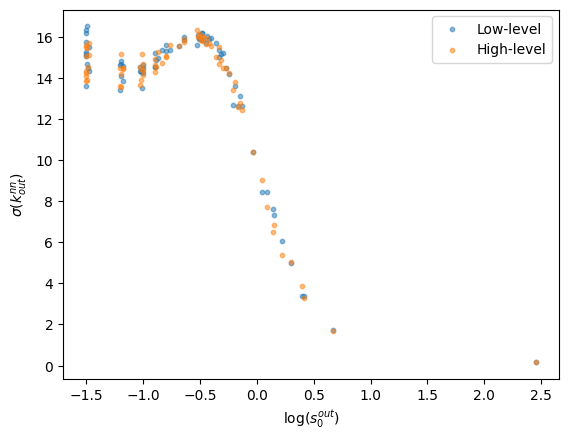

In [ ]:
plt.scatter(np.log10(out_strengths_400), ll_std_annd_out_400, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_400), hl_std_annd_out_400, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(k^{nn}_{out})$")
plt.legend()

### Local clustering coefficient

In [ ]:
ll_std_cl_coeff = np.nanstd([exp_cl_coeff_results[i][0] for i in range(len(exp_cl_coeff_results))], axis=0)
ll_std_cl_coeff_50 = np.nanstd([exp_cl_coeff_results_50[i][0] for i in range(len(exp_cl_coeff_results_50))], axis=0)
ll_std_cl_coeff_100 = np.nanstd([exp_cl_coeff_results_100[i][0] for i in range(len(exp_cl_coeff_results_100))], axis=0)
ll_std_cl_coeff_200 = np.nanstd([exp_cl_coeff_results_200[i][0] for i in range(len(exp_cl_coeff_results_200))], axis=0)
ll_std_cl_coeff_400 = np.nanstd([exp_cl_coeff_results_400[i][0] for i in range(len(exp_cl_coeff_results_400))], axis=0)

/Users/daviddobas/miniconda3/envs/network_renormalisation/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
hl_std_cl_coeff = np.nanstd([hl_exp_cl_coeff_results[i][0] for i in range(len(hl_exp_cl_coeff_results))], axis=0)
hl_std_cl_coeff_50 = np.nanstd([hl_exp_cl_coeff_results_50[i][0] for i in range(len(hl_exp_cl_coeff_results_50))], axis=0)
hl_std_cl_coeff_100 = np.nanstd([hl_exp_cl_coeff_results_100[i][0] for i in range(len(hl_exp_cl_coeff_results_100))], axis=0)
hl_std_cl_coeff_200 = np.nanstd([hl_exp_cl_coeff_results_200[i][0] for i in range(len(hl_exp_cl_coeff_results_200))], axis=0)
hl_std_cl_coeff_400 = np.nanstd([hl_exp_cl_coeff_results_400[i][0] for i in range(len(hl_exp_cl_coeff_results_400))], axis=0)

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1258526679.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), ll_std_cl_coeff_50, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/1258526679.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_50), hl_std_cl_coeff_50, s=10, alpha=.5, label="High-level")


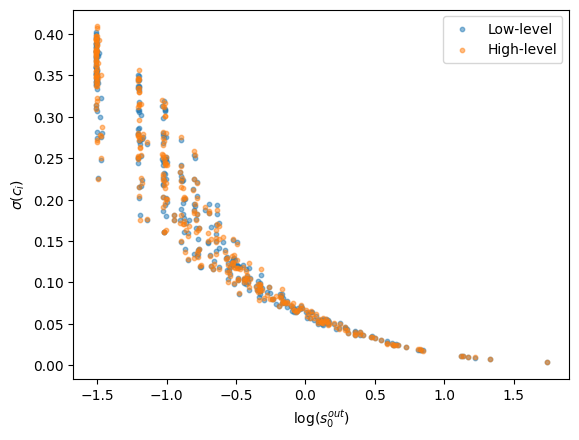

In [ ]:
plt.scatter(np.log10(out_strengths_50), ll_std_cl_coeff_50, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_50), hl_std_cl_coeff_50, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(c_i)$")
plt.legend()

/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3330423892.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_400), ll_std_cl_coeff_400, s=10, alpha=.5, label="Low-level")
/var/folders/td/zvch62c16b790gt_t6w8n5x80000gn/T/ipykernel_74908/3330423892.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(out_strengths_400), hl_std_cl_coeff_400, s=10, alpha=.5, label="High-level")


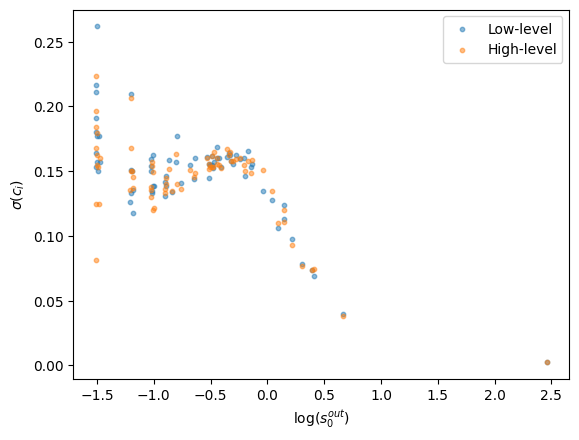

In [ ]:
plt.scatter(np.log10(out_strengths_400), ll_std_cl_coeff_400, s=10, alpha=.5, label="Low-level")
plt.scatter(np.log10(out_strengths_400), hl_std_cl_coeff_400, s=10, alpha=.5, label="High-level")
plt.xlabel(r"$\log(s_0^{out})$")
plt.ylabel(r"$\sigma(c_i)$")
plt.legend()

Test cl coeff

In [ ]:
und_gr = original_graph.as_undirected()

In [ ]:
adj_matrix = np.array(und_gr.get_adjacency().data)
np.fill_diagonal(adj_matrix, 0)

In [ ]:
result = np.zeros(adj_matrix.shape)
for i in range(1,len(adj_matrix)):
    result += adj_matrix*np.roll(adj_matrix, 1, axis=0)

In [ ]:
adj_matrix

array([[0, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 0, 0]])

In [ ]:
result

array([[  0., 499.,   0., ..., 499.,   0.,   0.],
       [  0.,   0.,   0., ..., 499.,   0., 499.],
       [499.,   0.,   0., ..., 499.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [499.,   0.,   0., ...,   0.,   0.,   0.],
       [499.,   0.,   0., ..., 499.,   0.,   0.]])